# Purpose for this code: 
As indicated by Fondazione Transform Transport ETS: data aggregation, filtering out, and populating the relative shapefile.
Tone of voice: logbook, not necessarily formal, but more on the practical side.

On the memory side of things, this notebook should probably not be ran altogether: 

- the first section (down until Objective #1) should be ran on its own, then saving the data, then eliminating all local variables (easiest way on Jupyter-lab or Notebook is to restart the kernel).
- from Objective #1 until the end of Objective #3 it can be ran altogether, as all the necessary files are imported and the memory usage is not aggravating on the device.
- from Objective #4 I recommend eliminating all local variables, as the necessary files are imported on the spot. 

In [2]:
import os
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import geoparquet as gpq # I tried geoparquet but it does not work properly, still unstable
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler #scales features based on percentiles, making it less sensitive to outliers
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.cluster.elbow import KElbowVisualizer
from yellowbrick.cluster import intercluster_distance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error

## Making one big dataset to represent 160.000 .txt files, correcting headers 
Always run cell below after restarting the kernel when processing raw data

In [100]:
# All datasets have an issue of spacing in the columns: the spacing is irregular.
header = "yyyy id   it imin dectime altitude azimuth kdir kdiff kglobal kdown   kup    keast ksouth kwest knorth ldown   lup    least lsouth lwest  lnorth   Ta      Tg     RH    Esky   Tmrt    I0     CI   Shadow  SVF_b  SVF_bv KsideI PET UTCI"
first_row = "1985 237 1 0 237.04167 -32.32 343.84 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 372.88 414.93 394.28 398.43 399.45 395.97 23.10 23.10 79.00 0.85 16.00 0.00 1.00 0.00 0.99 0.99 0.00 18.16 20.90"
print("length of original header row",len(header.split(" ")))
print("length of the first row", len(first_row.split(" ")))
clean_header = []
for c in header.split(" "):
    if c != "":   #every string unless it's empty
        clean_header.append(c)
print("length of the cleaned header row",len(clean_header))  #number of column names and first row values match: it's a wrap!

length of original header row 75
length of the first row 35
length of the cleaned header row 35


In [176]:
print(clean_header)

['yyyy', 'id', 'it', 'imin', 'dectime', 'altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown', 'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least', 'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0', 'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI']


### Exploring raw data, then concatenating it.
After seeing the many columns, I plan that for now I will just take the PET and UTCI values from each cell. 
The other values will be useful for clustering and getting a better description of each cell other than the PET and UTCI per hour, 

In [179]:
path = "Dataset 0/43_SOLWEIG_25_AGOSTO_2019"
df = pd.read_csv(path+"/POI_7945218.0.txt", skiprows=1, sep=' ')
first_row = df.columns
df.columns = clean_header
df.loc[-1] = first_row
df.head(5)

yyyy   id it imin    dectime altitude azimuth kdir kdiff kglobal  ...  \
0  1985  237  2    0  237.08333   -33.69    1.35  0.0   0.0     0.0  ...   
1  1985  237  3    0    237.125   -31.86   18.75  0.0   0.0     0.0  ...   
2  1985  237  4    0  237.16667   -27.14    34.8  0.0   0.0     0.0  ...   
3  1985  237  5    0  237.20833   -20.13   48.96  0.0   0.0     0.0  ...   
4  1985  237  6    0     237.25   -11.54   61.39  0.0   3.0     3.0  ...   

   Esky   Tmrt   I0   CI Shadow SVF_b SVF_bv KsideI    PET   UTCI  
0  0.85   19.4  0.0  1.0    0.0  0.65   0.53    0.0  19.28  22.46  
1  0.85  19.01  0.0  1.0    0.0  0.65   0.53    0.0  18.72   21.9  
2  0.85  18.32  0.0  1.0    0.0  0.65   0.53    0.0  17.98  21.21  
3  0.85  17.81  0.0  1.0    0.0  0.65   0.53    0.0  17.97  21.45  
4  0.85  17.91  0.0  1.0    0.0  0.65   0.53    0.0  18.45   21.9  

[5 rows x 35 columns]

In [4]:
folder_path = 'Dataset 0/43_SOLWEIG_25_AGOSTO_2019'

files = os.listdir(folder_path)

dfs_to_concatenate_later = []

for file_name in tqdm(files):
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path, delimiter=' ', skiprows=1)
    first_row = df.columns
    df.columns = clean_header
    df.loc[-1] = first_row  
    #the first row that would get lost otherwise, 
    #due to the nature of this code skipping the first line of wrongly spaced columns
    df = df[['it', 'PET', 'UTCI']] #setting only the id (integer after POI_ and before .txt of the filename)
    df.sort_index(inplace=True)
    df['id'] = file_name[4:-6]   
    dfs_to_concatenate_later.append(df)

one_array = pd.concat(dfs_to_concatenate_later)
dfs_to_concatenate_later = 0  #emptying the temporary df
print('Finished!')

100%|██████████████████████████████████| 160000/160000 [06:03<00:00, 439.73it/s]


Finished!


In [7]:
one_array

it    PET   UTCI       id
-1    1  20.05  22.79  8216791
 0    2  20.28  23.32  8216791
 1    3  19.64  22.76  8216791
 2    4  18.89  22.08  8216791
 3    5   19.0  22.35  8216791
..   ..    ...    ...      ...
 18  20  21.69  24.16  9257373
 19  21  20.43  23.42  9257373
 20  22  19.47  22.62  9257373
 21  23  18.18  20.44  9257373
 22   0  17.32  18.91  9257373

[3840000 rows x 4 columns]

### Saving the data as a .parquet to access it faster

In [8]:
for column in one_array.columns:
    print(one_array[f'{column}'].dtype)

one_array['id'] = one_array['id'].astype(int)
one_array['it'] = one_array['it'].astype(int)
one_array['PET'] = one_array['PET'].astype(float)
one_array['UTCI'] = one_array['UTCI'].astype(float)

for column in one_array.columns:
    print(one_array[f'{column}'].dtype)

int64
object
object
int64


ValueError: could not convert string to float: '18.99.1'

In [9]:
c = 0
for string in one_array.PET:
    try:
        float(string)
        continue
    except ValueError:
        print(string)
    if c == 20:
        break
    c += 1

18.99.1
19.00.1
18.99.1
18.99.1
18.99.1
19.00.1
18.99.1
19.00.1
18.99.1
19.00.1
19.00.1
19.00.1
19.00.1
18.99.1
18.99.1
19.00.1
18.99.1
19.00.1
19.00.1
18.99.1
18.99.1


There are some issues in the data, apparently these PET values cannot be turned into floats, and the same issue is found in UTCI. As an easy solution, I'll ignore the values after the second period.

In [10]:
for column in one_array.columns:
    print(one_array[f'{column}'].dtype)

one_array['PET'] = [float('.'.join(s.split('.')[:2])) for s in one_array['PET'].astype(str)]
one_array['UTCI'] = [float('.'.join(s.split('.')[:2])) for s in one_array['UTCI'].astype(str)]

for column in one_array.columns:
    print(one_array[f'{column}'].dtype)

int64
object
object
int64
int64
float64
float64
int64


In [11]:
one_array['it'] = one_array['it'].astype(bytes)
one_array.to_parquet("one_array_data0.parquet", engine='pyarrow')

_____________

My device (16 GB of RAM) at this points finds difficult to work with more data in a fast manner. My advice is to restart the kernel and read the data from the parquet file. 

In [5]:
one_array = pd.read_parquet("one_array_data0.parquet")
print(one_array.columns)
print(one_array.it.dtype, one_array.PET.dtype, one_array.UTCI.dtype)

Index(['it', 'PET', 'UTCI', 'id'], dtype='object')
object float64 float64


In [6]:
one_array

it    PET   UTCI       id
-1    b'1'  20.05  22.79  8216791
 0    b'2'  20.28  23.32  8216791
 1    b'3'  19.64  22.76  8216791
 2    b'4'  18.89  22.08  8216791
 3    b'5'  19.00  22.35  8216791
..     ...    ...    ...      ...
 18  b'20'  21.69  24.16  9257373
 19  b'21'  20.43  23.42  9257373
 20  b'22'  19.47  22.62  9257373
 21  b'23'  18.18  20.44  9257373
 22   b'0'  17.32  18.91  9257373

[3840000 rows x 4 columns]

In [7]:
lm = LinearRegression().fit(one_array[['PET']],one_array[['UTCI']])
r_squared = lm.score(one_array[['PET']],one_array[['UTCI']])
corr = np.corrcoef(one_array['PET'],one_array['UTCI'])
print(r_squared)
print(corr[0][1])

0.9833027273756876
0.991616219802646


In [8]:
pred = lm.predict(one_array[['PET']])

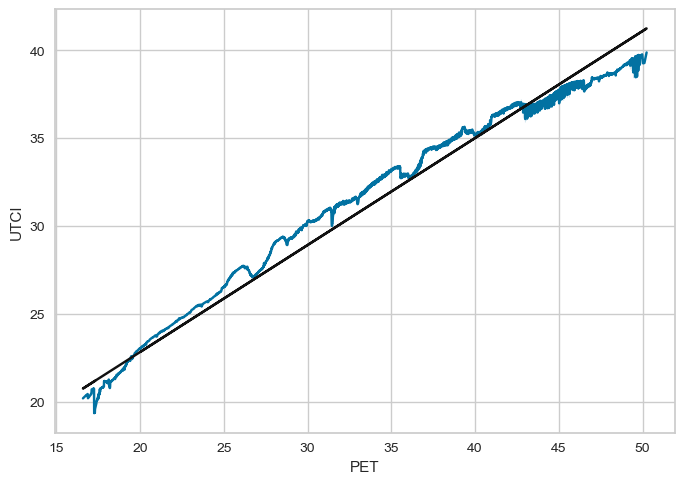

In [9]:
sns.lineplot(data = one_array.reset_index(), x= 'PET', y='UTCI')
plt.plot(one_array['PET'], pred, color='k')
plt.show()

PET and UTCI are not that different overall; one could predict the other very well given some noise.

In [10]:
one_array.id.unique().shape[0]

160000

# Objective #1. Populating the shapefile with hourly PET / UTCI data

In [3]:
GRID_POI_CC_Milan_5m = gpd.read_file('Dataset 1/43_GRID_POI_CC_Milan_5m.shp')

In [52]:
GRID_POI_CC_Milan_5m.area.unique() #it is indeed a 5x5 meters cells shp

array([25.])

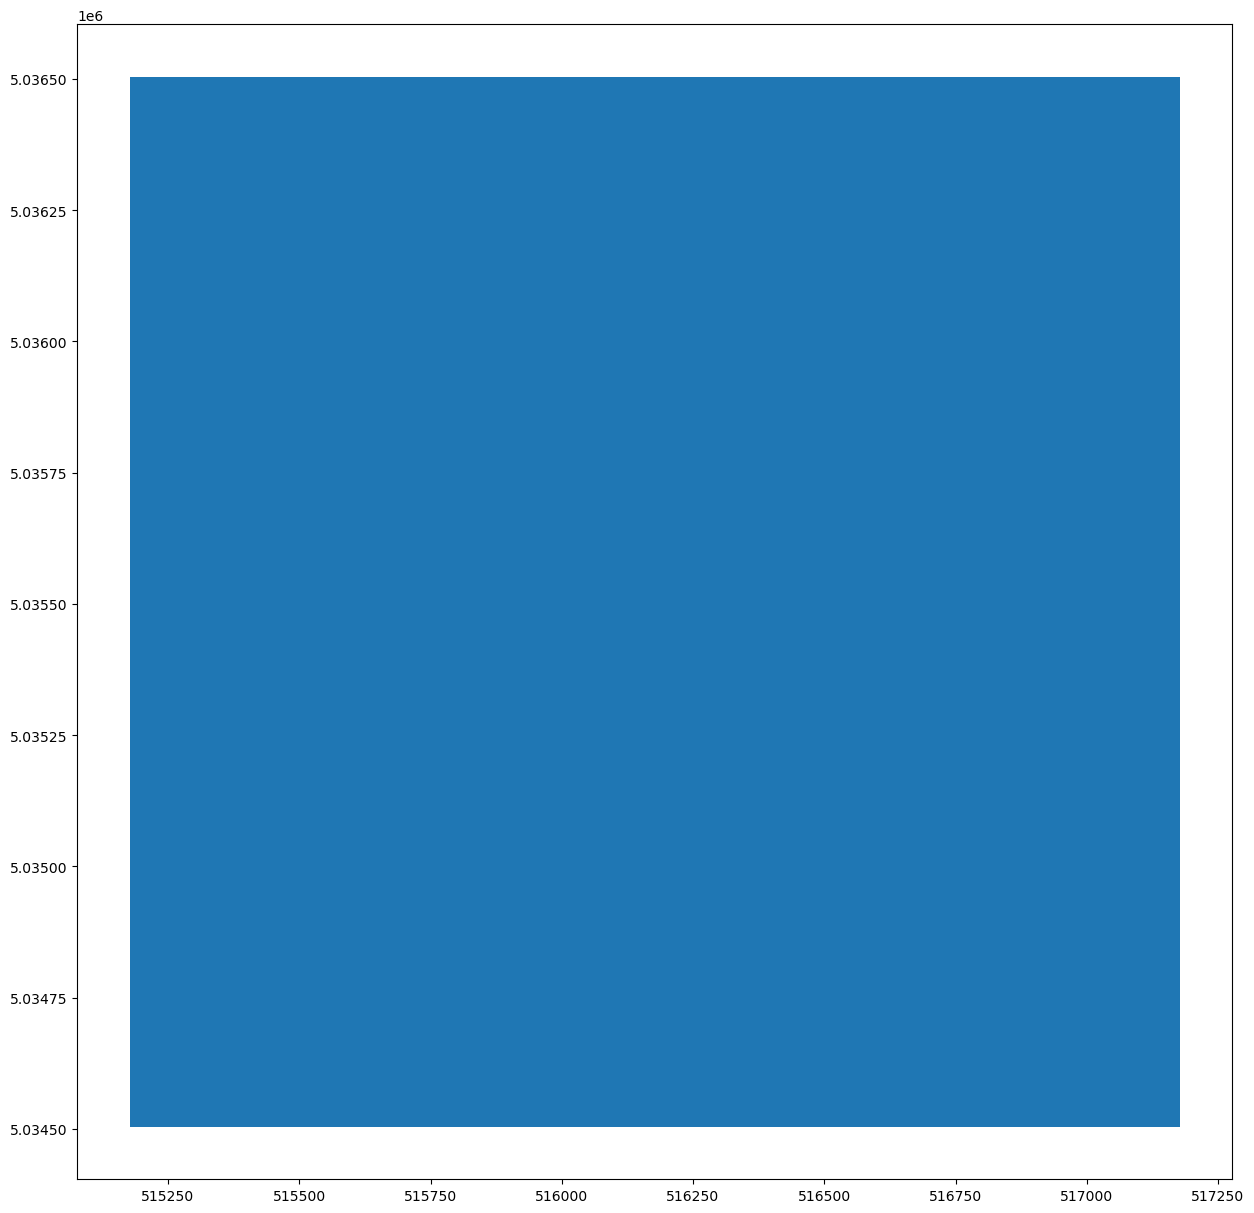

In [6]:
GRID_POI_CC_Milan_5m.plot(figsize=(15,15))
plt.show()

In [50]:
sum(GRID_POI_CC_Milan_5m.geometry.is_valid)  #there should be no mistakes in the geometries

NameError: name 'GRID_POI_CC_Milan_5m' is not defined

In [49]:
prj  = open("Dataset 1/43_GRID_POI_CC_Milan_5m.prj", "r")   #confirmed: it's the usual EPSG for Italy, EPSG=32632
prj.read().split(',')

['PROJCS["WGS_1984_UTM_Zone_32N"',
 'GEOGCS["GCS_WGS_1984"',
 'DATUM["D_WGS_1984"',
 'SPHEROID["WGS_1984"',
 '6378137.0',
 '298.257223563]]',
 'PRIMEM["Greenwich"',
 '0.0]',
 'UNIT["Degree"',
 '0.0174532925199433]]',
 'PROJECTION["Transverse_Mercator"]',
 'PARAMETER["False_Easting"',
 '500000.0]',
 'PARAMETER["False_Northing"',
 '0.0]',
 'PARAMETER["Central_Meridian"',
 '9.0]',
 'PARAMETER["Scale_Factor"',
 '0.9996]',
 'PARAMETER["Latitude_Of_Origin"',
 '0.0]',
 'UNIT["Meter"',
 '1.0]]']

In [9]:
GRID_POI_CC_Milan_5m

id BUILDING  ID_GRID  \
0       7945216.0      YES       43   
1       7945217.0     None       43   
2       7945218.0     None       43   
3       7945219.0     None       43   
4       7945220.0     None       43   
...           ...      ...      ...   
159995  8899451.0      YES       43   
159996  8899452.0     None       43   
159997  8899453.0     None       43   
159998  8899454.0     None       43   
159999  8899455.0      YES       43   

                                                 geometry  
0       POLYGON ((515182.316 5034709.132, 515187.316 5...  
1       POLYGON ((515182.316 5034704.132, 515187.316 5...  
2       POLYGON ((515182.316 5034699.132, 515187.316 5...  
3       POLYGON ((515182.316 5034694.132, 515187.316 5...  
4       POLYGON ((515182.316 5034689.132, 515187.316 5...  
...                                                   ...  
159995  POLYGON ((516622.316 5035694.132, 516627.316 5...  
159996  POLYGON ((516622.316 5035689.132, 516627.316 5...  
159997  POLYGON ((516622.316 5035684.132, 516627.316 5...  
159998  POLYGON ((516622.316 5035679.132, 516627.316 5...  
159999  POLYGON ((516622.316 5035674.132, 516627.316 5...  

[160000 rows x 4 columns]

# Objective #1 and #2. Data Aggregation and cleaning: Attempt #1
As I proceed associating the hourly PET and UTCI data with the respective cells on the shapefile, one problem arises: there are 24 observations for each cell, each representing one hour. However, one row on the shapefile represents only one cell: merging by cell ID would imply either **making multiple identical geometries** with only hourly attributes changes (which I do not know how QGIS would use) or **missing data**, by choosing one hour value. 
Simplified Example for solution A: 

*dataset 1* 

CELL ID___|__geometry ___|__PET __| __HOUR

____1________POLYGON(...)____23.4 ____1

____1________POLYGON(...)____25.4 ____2

...

____1________POLYGON(...)____25.4 ____23

____2________POLYGON(...)____19.4 ____1

.
.
.

____N________POLYGON(...)______Xn ____Xn
____________________________________

Simplified example for solution B: 

*dataset 1*

CELL ID___|__geometry ___|__PET __| __HOUR

____1________POLYGON(...)____23.4 ____1


____2________POLYGON(...)____14.4 ____1

____3________POLYGON(...)____15.0 ____1

.
.
.

____N________POLYGON(...)______Xn ____1

*dataset 2*

CELL ID___|__geometry ___|__PET __| __HOUR

____1________POLYGON(...)____26.4 ____2


____2________POLYGON(...)____20.4 ____2

____3________POLYGON(...)____30.4 ____2

.
.
.

____N________POLYGON(...)______Xn ____2


...

*dataset 23*

CELL ID___|__geometry ___|__PET __| __HOUR

____1________POLYGON(...) ____ 16.3 ____23


____2________POLYGON(...)____13.4 ____23

____3________POLYGON(...)____26.4 ____23

.
.
.

____N________POLYGON(...)______Xn ____


As the second solution seems more practical (I wouldn't want to take one hour or the mean value per day as I would miss much information) so to proceed I will merge 24 different datasets each representing the value per hour (until a better solution is found!)

In [18]:
one_array.loc[:, 'id'] = one_array.id.astype(int)
one_array.loc[:,'it'] = one_array.it.astype(int)
GRID_POI_CC_Milan_5m.id = GRID_POI_CC_Milan_5m.id.astype(int)

In [ ]:
#This is frozen due to a better implementation later.

# for h in one_array.it.unique():
#     path = f"./Dataset 1/hour_{h}"
#     results = GRID_POI_CC_Milan_5m.merge(one_array[one_array.it == h], how = 'left', on='id')
#     print(f"path: {path}")
#     print(f'object:', type(results), "with columns", results.columns)
#     print()
#     os.mkdir(path)
#     results.to_file(f"{path}/GRID_POI_CC_Milan_5m_{h}.shp")

### Filtering cells: overlap Vs no overlap
Using QGIS,I overlapped the buldings onto the grid. By using QGIS' feature: "Vector Overlay" > "Intersection" from the processing toolbox, I ran its algorithm and I obtained a list of cells from the grid that either overlapped with buildings or didn't as a csv.

In [ ]:
Intersection_GRID_BUILDINGS_Milan = gpd.read_file("Intersection/Intersection_GRID_BUILDINGS_Milan.shp")

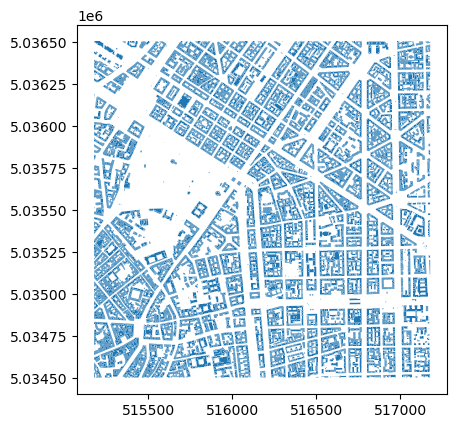

In [54]:
Intersection_GRID_BUILDINGS_Milan.plot()
plt.show()

In [22]:
print(Intersection_GRID_BUILDINGS_Milan.BUILDING.dtype)
Intersection_GRID_BUILDINGS_Milan.BUILDING = Intersection_GRID_BUILDINGS_Milan.BUILDING.astype(str)
print(Intersection_GRID_BUILDINGS_Milan.BUILDING.dtype)

object
object


In [23]:
non_overlapping_cells = GRID_POI_CC_Milan_5m[~GRID_POI_CC_Milan_5m.id.isin(Intersection_GRID_BUILDINGS_Milan.id)].copy(deep=True)
print(non_overlapping_cells.shape[0])

67053


In [24]:
print(f"Around {(non_overlapping_cells.shape[0] / GRID_POI_CC_Milan_5m.id.unique().shape[0]) * 100:.2f}% of the cells from the grid are not overlapping with buildings.")

Around 41.91% of the cells from the grid are not overlapping with buildings.


I'll pick those! 

In [25]:
non_overlapping_cells

id BUILDING  ID_GRID  \
2       7945218     None       43   
3       7945219     None       43   
4       7945220     None       43   
5       7945221     None       43   
6       7945222     None       43   
...         ...      ...      ...   
159973  8899429     None       43   
159983  8899439     None       43   
159984  8899440     None       43   
159997  8899453     None       43   
159998  8899454     None       43   

                                                 geometry  
2       POLYGON ((515182.316 5034699.132, 515187.316 5...  
3       POLYGON ((515182.316 5034694.132, 515187.316 5...  
4       POLYGON ((515182.316 5034689.132, 515187.316 5...  
5       POLYGON ((515182.316 5034684.132, 515187.316 5...  
6       POLYGON ((515182.316 5034679.132, 515187.316 5...  
...                                                   ...  
159973  POLYGON ((516622.316 5035804.132, 516627.316 5...  
159983  POLYGON ((516622.316 5035754.132, 516627.316 5...  
159984  POLYGON ((516622.316 5035749.132, 516627.316 5...  
159997  POLYGON ((516622.316 5035684.132, 516627.316 5...  
159998  POLYGON ((516622.316 5035679.132, 516627.316 5...  

[67053 rows x 4 columns]

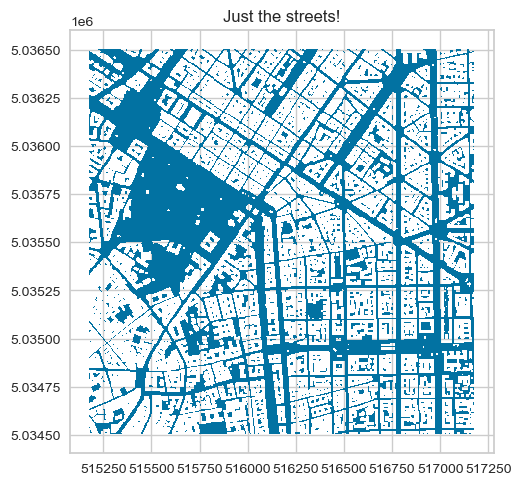

In [26]:
non_overlapping_cells.plot()
plt.title('Just the streets!')
plt.show()

In [27]:
#Substituting hourly data
cells_to_keep = one_array[one_array.id.isin(non_overlapping_cells.id)]
cells_to_keep

it    PET   UTCI       id
0         1  20.05  22.79  8216791
1         2  20.28  23.32  8216791
2         3  19.64  22.76  8216791
3         4  18.89  22.08  8216791
4         5  19.00  22.35  8216791
...      ..    ...    ...      ...
3839875  20  23.16  25.29  8239991
3839876  21  21.81  24.48  8239991
3839877  22  20.78  23.71  8239991
3839878  23  19.17  21.49  8239991
3839879   0  18.70  20.50  8239991

[1609272 rows x 4 columns]

### Saving the file

In [28]:
# This part is frozen due to a better later implementation
 

# for h in cells_to_keep.it.unique():
#     path = f"./Dataset 1/hour_{h}"
#     results = GRID_POI_CC_Milan_5m.merge(cells_to_keep[cells_to_keep.it == h], how = 'left', on='id')
#     print(f"path: {path}")
#     print(f'object:', type(results), "with columns", results.columns)
#     print()
#     os.mkdir(path)
#     results.to_file(f"{path}/GRID_POI_CC_Milan_5m_{h}.shp")

## Data Aggregation and Cleaning: Attempt #2 and only with cells that do not mostly overlap on buildings.
I realized: it doesn't take much to add 24 columns as attributes for each cell to the grid shapefile, so that then I wouldn't have multiple rows with the same cell ID. 

In [29]:
non_overlapping_cells

id BUILDING  ID_GRID  \
2       7945218     None       43   
3       7945219     None       43   
4       7945220     None       43   
5       7945221     None       43   
6       7945222     None       43   
...         ...      ...      ...   
159973  8899429     None       43   
159983  8899439     None       43   
159984  8899440     None       43   
159997  8899453     None       43   
159998  8899454     None       43   

                                                 geometry  
2       POLYGON ((515182.316 5034699.132, 515187.316 5...  
3       POLYGON ((515182.316 5034694.132, 515187.316 5...  
4       POLYGON ((515182.316 5034689.132, 515187.316 5...  
5       POLYGON ((515182.316 5034684.132, 515187.316 5...  
6       POLYGON ((515182.316 5034679.132, 515187.316 5...  
...                                                   ...  
159973  POLYGON ((516622.316 5035804.132, 516627.316 5...  
159983  POLYGON ((516622.316 5035754.132, 516627.316 5...  
159984  POLYGON ((516622.316 5035749.132, 516627.316 5...  
159997  POLYGON ((516622.316 5035684.132, 516627.316 5...  
159998  POLYGON ((516622.316 5035679.132, 516627.316 5...  

[67053 rows x 4 columns]

In [30]:
cells_to_keep = one_array[one_array.id.isin(non_overlapping_cells.id)].pivot(index=['id'], values=['PET'], columns=['it'])['PET']
cells_to_keep.columns = 'h' + cells_to_keep.columns.astype(str)
cells_to_keep.reset_index(inplace=True)
print(cells_to_keep.columns)
cells_to_keep

Index(['id', 'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10',
       'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20',
       'h21', 'h22', 'h23'],
      dtype='object', name='it')


it          id     h0     h1     h2     h3     h4     h5     h6     h7     h8  \
0      7941545  17.89  18.91  18.98  18.43  17.69  17.64  18.10  18.90  21.48   
1      7941546  17.78  18.78  18.83  18.29  17.55  17.48  17.92  18.71  21.35   
2      7941547  17.85  18.86  18.92  18.37  17.63  17.58  18.03  18.82  21.42   
3      7941548  17.97  19.01  19.08  18.53  17.79  17.75  18.21  19.02  21.55   
4      7941549  17.91  18.94  19.00  18.45  17.71  17.67  18.12  18.92  21.45   
...        ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
67048  9264197  17.70  18.68  18.71  18.18  17.44  17.36  17.79  18.57  31.79   
67049  9264198  17.75  18.74  18.78  18.25  17.51  17.44  17.88  18.66  31.84   
67050  9264206  17.46  18.40  18.40  17.88  17.15  17.03  17.43  18.19  31.50   
67051  9264223  17.59  18.56  18.58  18.05  17.31  17.22  17.63  18.41  31.63   
67052  9264224  17.69  18.67  18.70  18.17  17.43  17.35  17.78  18.56  31.76   

it     ...    h14    h15    h16    h17    h18    h19    h20    h21    h22  \
0      ...  47.93  48.11  47.95  39.80  33.26  28.96  22.93  20.85  19.83   
1      ...  47.49  47.65  47.50  39.56  33.11  28.83  22.75  20.72  19.73   
2      ...  47.51  47.70  47.57  39.60  33.16  28.92  22.85  20.80  19.79   
3      ...  47.44  47.59  47.44  39.59  33.21  29.06  23.00  20.94  19.91   
4      ...  47.24  47.23  47.07  39.38  33.13  29.01  22.92  20.87  19.85   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
67048  ...  47.08  33.39  31.81  29.48  26.36  23.76  21.59  20.77  19.76   
67049  ...  46.95  33.31  31.84  29.43  26.39  23.80  21.65  20.83  19.81   
67050  ...  47.04  46.49  46.24  38.78  32.58  23.99  21.47  20.51  19.54   
67051  ...  47.23  33.82  32.29  29.64  32.30  28.63  21.83  20.64  19.65   
67052  ...  47.07  33.53  32.06  29.54  26.57  28.44  21.84  20.77  19.76   

it       h23  
0      18.48  
1      18.40  
2      18.45  
3      18.55  
4      18.49  
...      ...  
67048  18.42  
67049  18.47  
67050  18.24  
67051  18.33  
67052  18.42  

[67053 rows x 25 columns]

### Saved the file from the more successful attempt.

In [31]:
results = GRID_POI_CC_Milan_5m[GRID_POI_CC_Milan_5m.id.isin(non_overlapping_cells.id)].merge(cells_to_keep, how = 'left', on='id')
results.to_file(f"Dataset 1/populated with data/GRID_POI_CC_Milan_5m_hourlyPET.shp")

<Axes: >

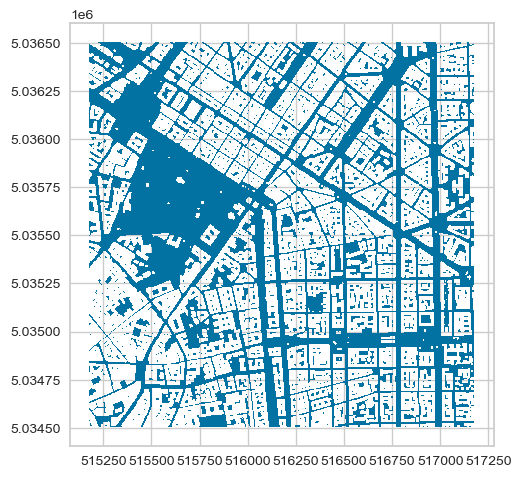

In [33]:
results.plot()

<Axes: >

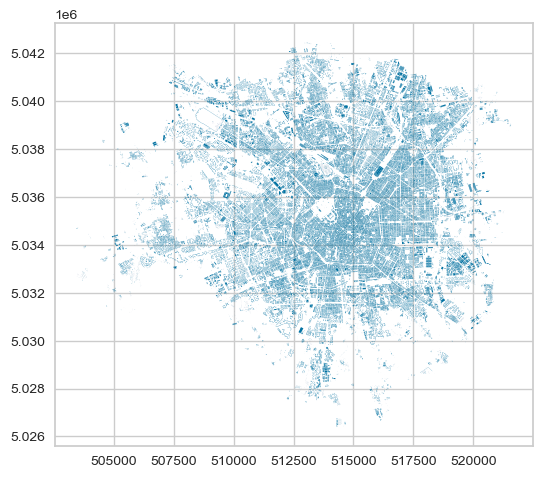

In [34]:
buildings = gpd.read_file("Dataset 2/Edifici_Milano.shp")
buildings.plot()

_________________

# Objective #3. Data simplification
<div>
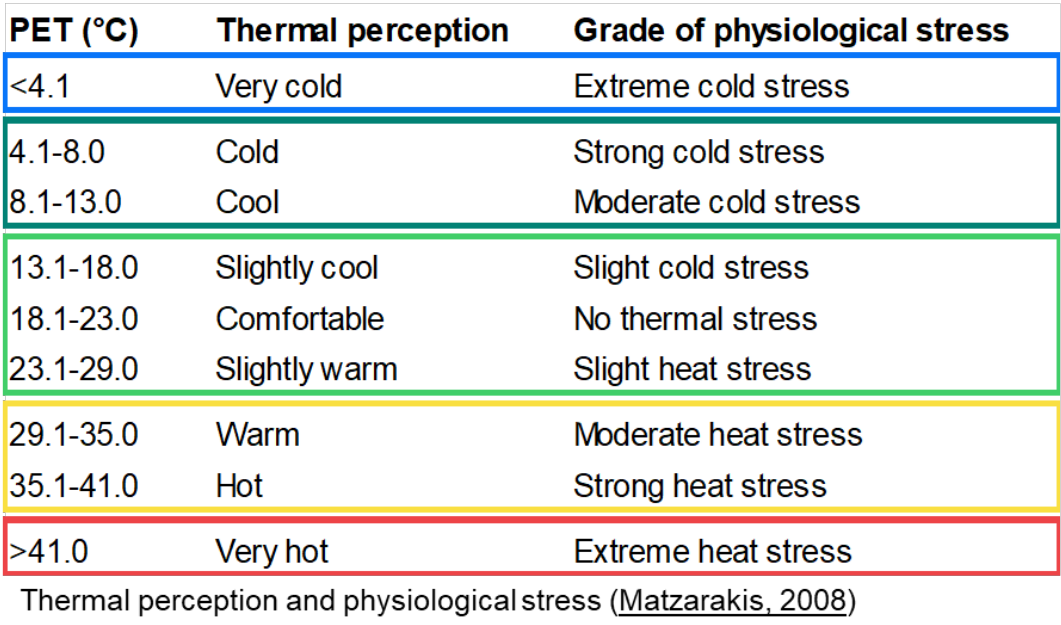
</div>

The table above will be used to establish thresholds. 

Cold physiological stress goes from extreme to strong cold: 

PET $\leq$ 8.0

Comfortable phys. condition goes from moderate cold to moderate heat: 

8.0 $<$ PET $\leq$ 35.0

Heat phys. stress goes from strong to extreme heat stress:

35.0 $<$ PET

In [35]:
thresholds = [ [-50, 8.0], [8.1, 35], [35.1, 100]]
thresholds

[[-50, 8.0], [8.1, 35], [35.1, 100]]

In [36]:
results.columns

Index(['id', 'BUILDING', 'ID_GRID', 'geometry', 'h0', 'h1', 'h2', 'h3', 'h4',
       'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15',
       'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23'],
      dtype='object')

PET ≤ 8.0

8.0 < PET ≤ 35.0

35.0 < PET


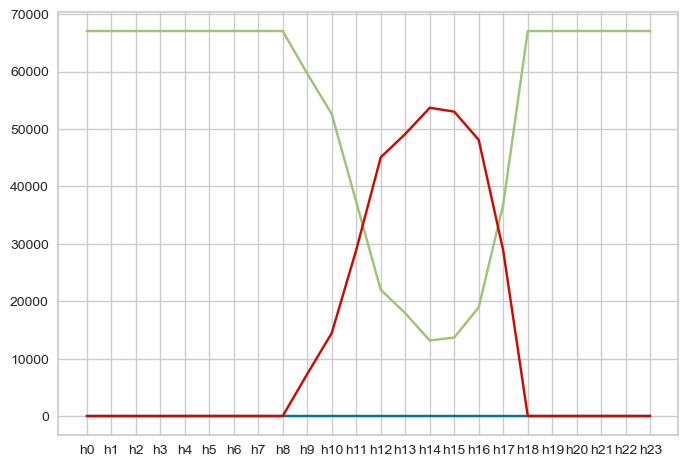

In [43]:
#The output of this cell is to only check the general distribution per hour, not per cell. 
#Cold is absent, while the hottest hours take place in the middle to late hours of daylight (as expected)
print('PET ≤ 8.0')
plt.plot((results[['h0', 'h1', 'h2', 'h3', 'h4',
       'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15',
       'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']] <= thresholds[0][1]).sum())
print()
print('8.0 < PET ≤ 35.0')
plt.plot(((results[['h0', 'h1', 'h2', 'h3', 'h4',
       'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15',
       'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']] >= thresholds[1][0]) & (
    results[['h0', 'h1', 'h2', 'h3', 'h4',
       'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15',
       'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']] <= thresholds[1][1])).sum())
print()
print('35.0 < PET')
plt.plot((results[['h0', 'h1', 'h2', 'h3', 'h4',
       'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15',
       'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']] > thresholds[2][0]).sum())
plt.show()

In [44]:
results['cold_h'] = (results[['h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']] <= thresholds[0][1] 
                    ).sum(axis=1)
results['comf_h'] = ((results[['h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']] >= thresholds[1][0]) & (
    results[['h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']] <= thresholds[1][1])
).sum(axis=1)
results['heat_h'] = (results[['h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']] >= thresholds[2][0] ).sum(axis=1)

In [45]:
# There are some cells without exactly 24 hours,but they are not many. This is a limitation, and these cells will be sieved out.
mask = ['cold_h', 'comf_h', 'heat_h']
print(results[mask].sum(axis=1).value_counts())

#list comprehension version
to_drop = [results.iloc[i].id if (results[mask].iloc[i].sum() < 24) else 'to_keep' for i in range(results[mask].shape[0])]

#interpretable version of the loop:
# to_drop = []

# for i in tqdm(range(results[mask].shape[0])):
#     r = results[mask].iloc[i].sum()
#     if r < 24:
#         to_drop.append(results.iloc[i].id)

24    64458
23     2547
22       48
Name: count, dtype: int64


In [46]:
pd.DataFrame(to_drop).value_counts() # Found them!

0      
to_keep    64458
8912837        1
8902923        1
8905949        1
8906015        1
           ...  
8375814        1
8375841        1
8375842        1
8375843        1
8627903        1
Name: count, Length: 2596, dtype: int64

In [47]:
df = results[~results.id.isin(to_drop)]
print(df.shape[0])

64458


In [48]:
df.id.to_csv('id_filtered_cells.csv')

# Objective #4. Data Clustering

In [95]:
id_filtered_cells = pd.read_csv('id_filtered_cells.csv')[['id']]

In [101]:
folder_path = 'Dataset 0/43_SOLWEIG_25_AGOSTO_2019'

 #here I am selecting only the cells that are eligible for the analysis
files = 'POI_'+id_filtered_cells.id.astype(str)+'.0.txt' 

dfs_to_concatenate_later = []

for file_name in tqdm(files):
    file_path = os.path.join(folder_path, file_name)
    cell = pd.read_csv(file_path, delimiter=' ', skiprows=1)
    first_row = cell.columns
    cell.columns = clean_header
    cell.loc[-1] = first_row  
    #the first row that would get lost otherwise, 
    #due to the nature of this code skipping the first line of wrongly spaced columns

    cell.sort_index(inplace=True)
    cell['id'] = file_name[4:-6]   
    dfs_to_concatenate_later.append(cell)

clustering_df = pd.concat(dfs_to_concatenate_later)
dfs_to_concatenate_later = 0  #emptying the temporary df
print('Finished!')

100%|████████████████████████████████████████████████████████████████████████████████████████████| 64458/64458 [02:13<00:00, 483.87it/s]


Finished!


In [102]:
print(f"The length of this dataframe is equal to \nthe number of cells {clustering_df.id.unique().shape[0]:,} \
times 24 hours: {clustering_df.id.unique().shape[0] * clustering_df.it.unique().shape[0]:,}")

The length of this dataframe is equal to 
the number of cells 64,458 times 24 hours: 1,546,992


In [103]:
clustering_df = clustering_df[['id', 'it', 'altitude', 'azimuth', 'kdir', 
               'kdiff', 'kglobal', 'kdown', 'kup', 'keast', 'ksouth', 'kwest',
               'knorth', 'ldown', 'lup', 'least', 'lsouth', 'lwest', 'lnorth', 'Ta',
               'Tg', 'RH', 'Esky', 'Tmrt', 'I0', 'CI', 'Shadow', 'SVF_b', 'SVF_bv',
               'KsideI', 'PET', 'UTCI']]   #dropping the year, the imin, the dectime

From the UMEP manual: the meaning of the columns (except for ID: ID is **not** the day of the year but the name of the cell on the geographical data)
<div>
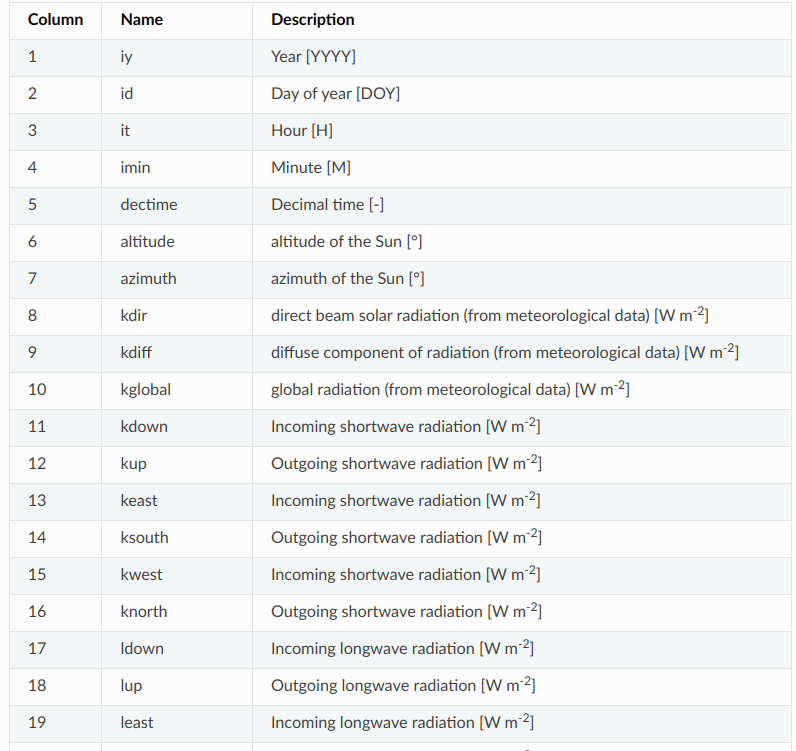
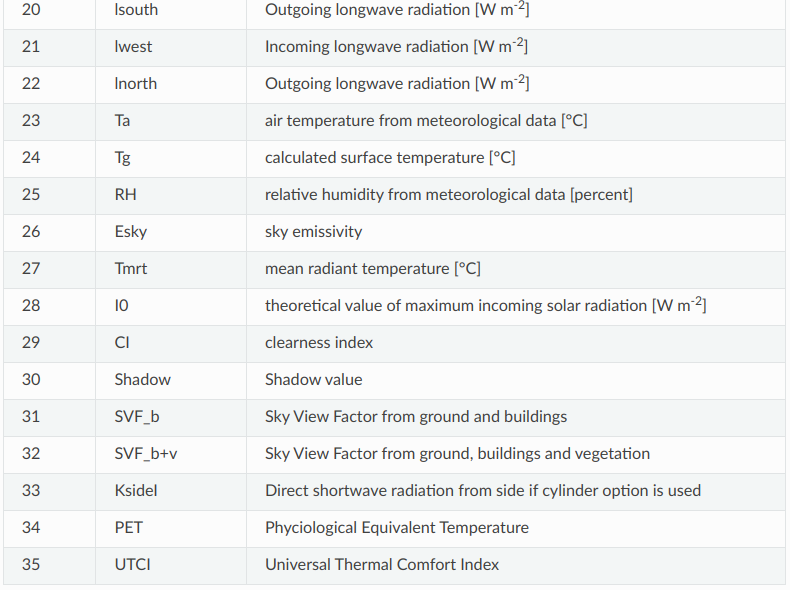
</div>

The time precision is down to the hour, not to the minute, so dectime and minute become irrelevant.

In [104]:
clustering_df.head() 

id it altitude azimuth  kdir   kdiff kglobal   kdown     kup   keast  \
-1  7945218  1   -32.32  343.84  0.00  0.00.1  0.00.2  0.00.3  0.00.4  0.00.5   
 0  7945218  2   -33.69    1.35   0.0     0.0     0.0     0.0     0.0     0.0   
 1  7945218  3   -31.86   18.75   0.0     0.0     0.0     0.0     0.0     0.0   
 2  7945218  4   -27.14    34.8   0.0     0.0     0.0     0.0     0.0     0.0   
 3  7945218  5   -20.13   48.96   0.0     0.0     0.0     0.0     0.0     0.0   

    ...  Esky   Tmrt      I0    CI   Shadow SVF_b SVF_bv   KsideI    PET  \
-1  ...  0.85  19.70  0.00.9  1.00  0.00.10  0.65   0.53  0.00.11  19.19   
 0  ...  0.85   19.4     0.0   1.0      0.0  0.65   0.53      0.0  19.28   
 1  ...  0.85  19.01     0.0   1.0      0.0  0.65   0.53      0.0  18.72   
 2  ...  0.85  18.32     0.0   1.0      0.0  0.65   0.53      0.0  17.98   
 3  ...  0.85  17.81     0.0   1.0      0.0  0.65   0.53      0.0  17.97   

     UTCI  
-1  21.95  
 0  22.46  
 1   21.9  
 2  21.21  
 3  21.45  

[5 rows x 32 columns]

**Fixing** the values with incoherent format: I do not find resources explaining why the format of some columns is divided between two periods, e.g. 00.00.01 , as it there is no timestamps or categorical values in the columns in occurs. I will use the code used before to correct PET entries. 

I see a pattern. The first line of the cell 7945218 has some unusual values, and they seem to follow an order: it seems like the output of certain hours was a mistake. I assume this is what happened: 

At hour 1, cell 7945218 does not have a number output, and the model outputted errors that are **numbered**, in the order of the columns, which is why 
- kdir's entry's last value  is 0,
- kdiff is 1,
- kglobal is 2,

and so on for all the entries that are NaN until Ksidel, which is 11th on the list of errors. Replacing these with 0 is my solution, as these values usually indicate phenomena that occur in the day (sensible solar radiation changes), and not at night.

In [106]:
clustering_df[['it', 'Shadow']].head(6)  #00.00.1 shadow at 1 a.m. makes no sense; it should be replaced with 0)
clustering_df[['it', 'kdiff']].head(6)   #also diffuse solar radiation at night makes no sense
clustering_df[['it', 'kglobal']].head(6) #"..."
clustering_df[['it', 'kdown']].head(6)   #

it   kdown
-1  1  0.00.3
 0  2     0.0
 1  3     0.0
 2  4     0.0
 3  5     0.0
 4  6     0.0

In [107]:
#the following operation was done previously in this notebook, for explanation read that part
clustering_df['PET'] = [float('.'.join(s.split('.')[:2])) for s in clustering_df['PET'].astype(str)]
clustering_df['UTCI'] = [float('.'.join(s.split('.')[:2])) for s in clustering_df['UTCI'].astype(str)]

problematic_columns = []
for col in clustering_df.columns:
    try:
        clustering_df[f'{col}'] = clustering_df[f'{col}'].astype(float)
    except ValueError:
        problematic_columns.append(col)
        print('2 Examples from column:', col)
        c = 0
        for string in clustering_df[f'{col}']:
            try:
                float(string)
            except ValueError:
                print(string)
                if c == 1:
                    break
                c += 1
            
        print()

# There are more than 11 mistakes or unusual format in entries: I count 20 excluding PET and UTCI, already corrected. 

2 Examples from column: kdiff
0.00.1
0.00.1

2 Examples from column: kglobal
0.00.2
0.00.2

2 Examples from column: kdown
0.00.3
0.00.3

2 Examples from column: kup
0.00.4
0.00.4

2 Examples from column: keast
0.00.5
0.00.5

2 Examples from column: ksouth
0.00.6
0.00.6

2 Examples from column: kwest
0.00.7
0.00.7

2 Examples from column: knorth
0.00.8
0.00.8

2 Examples from column: lup
414.93.1
414.93.1

2 Examples from column: least
401.76.1
414.11.1

2 Examples from column: lsouth
414.93.1
414.93.1

2 Examples from column: lwest
430.53.1
440.08.1

2 Examples from column: lnorth
414.93.1
436.52.1

2 Examples from column: Tg
23.10.1
23.10.1

2 Examples from column: Tmrt
23.10.2
23.10.2

2 Examples from column: I0
0.00.9
0.00.9

2 Examples from column: Shadow
0.00.10
0.00.10

2 Examples from column: SVF_b
0.85.1
0.85.1

2 Examples from column: SVF_bv
0.70.1
0.56.1

2 Examples from column: KsideI
0.00.11
0.00.11



It seems like most of these unusual formats are just the actual value + .n attached at the end. So I will take from these features only the entry down to the 2 values after the first period (from left to right)

In [108]:
for col in problematic_columns:
    clustering_df[f'{col}'] = [float('.'.join(s.split('.')[:2])) for s in clustering_df[f'{col}'].astype(str)]

#the rest should get by using simply pandas functions
for col in set(problematic_columns) - set(clustering_df.columns):
    clustering_df[f'{col}'] = clustering_df[f'{col}'].astype(float)

#check
for col in clustering_df.columns:
    if clustering_df[f'{col}'].dtype != "float64":
        print('there is a mistake for column', col)
print('Done!')

Done!


In [109]:
for col in clustering_df.columns:
    try:
        clustering_df[f'{col}'] = clustering_df[f'{col}'].astype(float)
    except ValueError:
        problematic_columns.append(col)
        print('2 Examples from column:', col)
        c = 0
        for string in clustering_df[f'{col}']:
            try:
                float(string)
            except ValueError:
                print(string)
                if c == 1:
                    break
                c += 1
            
        print()

#This for loop should print nothing, as it found no issues seen before!

In [110]:
clustering_df.to_parquet("clustering_df_NOT_NORMALIZED.parquet")

**Normalizing** the variables before any use

In [14]:
clustering_df.columns

Index(['id', 'it', 'altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI'],
      dtype='object')

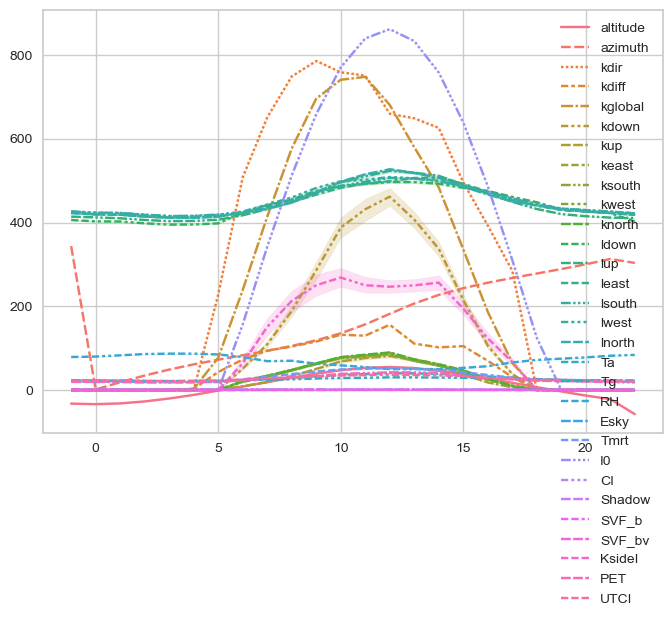

In [23]:
#Before rescaling:
X1 = pd.DataFrame(clustering_df[['altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',   #this X1 is only for plotting
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI']].sample(n=10000, random_state=25))
sns.lineplot(X1)
plt.show() 

In [24]:
scaler = RobustScaler()

for col in ['altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI' ]:   #all features but id and hour
    clustering_df[[f'{col}']] = scaler.fit_transform(clustering_df[[f'{col}']])
print('Done!')

Done!


In [25]:
clustering_df.head(4)

id   it  altitude   azimuth      kdir     kdiff  kglobal     kdown  \
-1  7945218.0  1.0 -0.685215  0.918749 -0.394919 -0.354916 -0.13997 -0.030655   
 0  7945218.0  2.0 -0.708672 -0.885611 -0.394919 -0.354916 -0.13997 -0.030655   
 1  7945218.0  3.0 -0.677339 -0.793941 -0.394919 -0.354916 -0.13997 -0.030655   
 2  7945218.0  4.0 -0.596524 -0.709384 -0.394919 -0.354916 -0.13997 -0.030655   

         kup     keast  ...  Esky      Tmrt        I0   CI  Shadow     SVF_b  \
-1 -0.017994 -0.045445  ...   0.0 -0.235356 -0.218713  0.0     0.0 -0.032258   
 0 -0.017994 -0.045445  ...   0.0 -0.251187 -0.218713  0.0     0.0 -0.032258   
 1 -0.017994 -0.045445  ...   0.0 -0.271768 -0.218713  0.0     0.0 -0.032258   
 2 -0.017994 -0.045445  ...   0.0 -0.308179 -0.218713  0.0     0.0 -0.032258   

      SVF_bv  KsideI       PET      UTCI  
-1  0.242424     0.0 -0.224373 -0.289612  
 0  0.242424     0.0 -0.217921 -0.236097  
 1  0.242424     0.0 -0.258065 -0.294858  
 2  0.242424     0.0 -0.311111 -0.367261  

[4 rows x 32 columns]

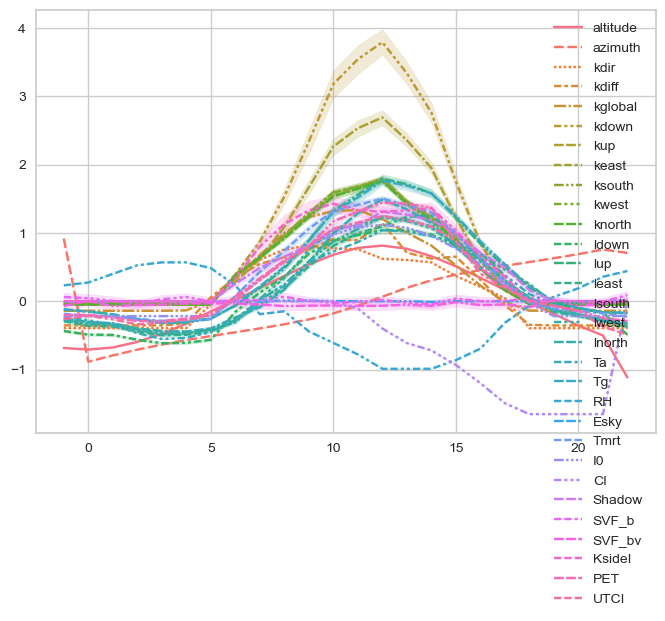

In [26]:
X1 = pd.DataFrame(clustering_df[['altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',   #this X1 is only for plotting
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI']].sample(n=10000, random_state=25))
sns.lineplot(X1)
plt.show() 

### Saving clean, standardized clustering data

In [27]:
clustering_df.to_parquet('clustering_data.parquet')

In [225]:
# In case there is a need to restart the kernel or you just want to start from here:
clustering_df = pd.read_parquet('clustering_data.parquet')

### K = 3

In [238]:
K = 3

kmeans_3 = KMeans(n_clusters=K, random_state=25)

clustering_df['cluster'] = kmeans_3.fit_predict(clustering_df[['altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI']])

In [240]:
cluster_means = clustering_df[['altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI', 'cluster']].groupby('cluster').mean()

In [241]:
cluster_means.sort_values(by='altitude')

altitude   azimuth      kdir     kdiff   kglobal     kdown       kup  \
cluster                                                                         
1       -0.391156 -0.010527 -0.255210 -0.224494 -0.056490  0.022732  0.021673   
0        0.486759  0.076349  0.533327  0.605177  0.776362  1.045007  0.830001   
2        0.687803  0.028652  0.663582  0.833502  1.101199  4.447846  3.010387   

            keast    ksouth     kwest  ...      Esky      Tmrt        I0  \
cluster                                ...                                 
1        0.016157  0.013239  0.011274  ...  0.000704 -0.155852 -0.143478   
0        0.800836  0.792273  0.794608  ...  0.001539  0.697090  0.720659   
2        1.769490  1.797880  1.749664  ...  0.000299  1.727724  0.978643   

               CI    Shadow     SVF_b    SVF_bv    KsideI       PET      UTCI  
cluster                                                                        
1       -0.535378  0.018398 -0.001898 -0.049626  0.010613 -0.155573 -0.194942  
0       -0.536465  0.512635 -0.041943 -0.236079  0.601032  0.648970  0.622139  
2       -0.345932  1.789576  0.183738  0.172832  2.177838  1.523315  1.284140  

[3 rows x 30 columns]

In [229]:
pca = PCA(n_components=3)
pca.fit(clustering_df[['altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI']])
reduced_features = pca.transform(clustering_df[['altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI']])

reduced_df = pd.DataFrame(reduced_features, index=clustering_df.index, columns=['PC1','PC2', 'PC3'])
reduced_df['cluster'] = clustering_df['cluster']
reduced_df.head()

PC1       PC2       PC3  cluster
-1 -2.773857  0.499758  0.402729        1
 0 -2.836680  0.938923 -0.404175        1
 1 -2.927455  1.009162 -0.382211        1
 2 -3.065530  1.127138 -0.379754        1
 3 -3.131044  1.183359 -0.381210        1

In [242]:
centres_reduced = pca.transform(kmeans_3.cluster_centers_)

/home/fluve/anaconda3/envs/python3_8/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


#### plotting function that I did not find in PCA module

In [231]:
# From github: https://github.com/OpenClassrooms-Student-Center/Multivariate-Exploratory-Analysis/blob/master/functions.py  
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)

#### visualization

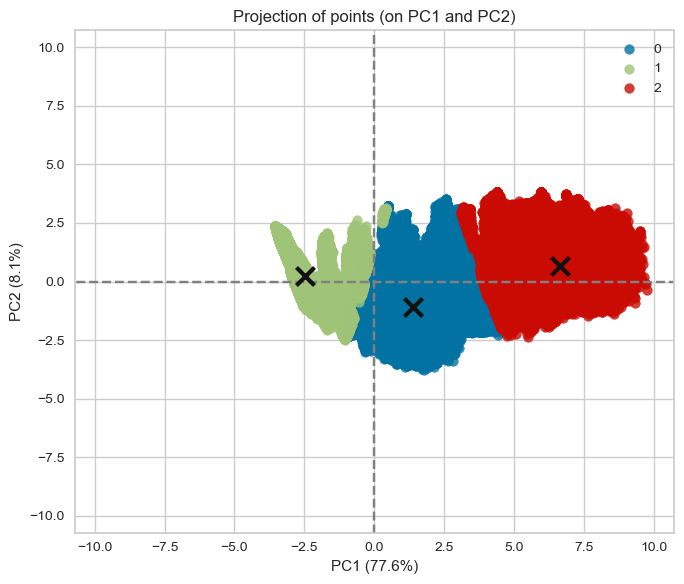

In [243]:
display_factorial_planes(reduced_features, 3, pca, [(0,1)], illustrative_var = clustering_df['cluster'], alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=3,
            color='k', zorder=10)
plt.tight_layout()
plt.savefig("Graphs/PCA_two_dimensions_3Means.png", dpi=500)
plt.show()

### k = 5

In [244]:
K = 5

kmeans = KMeans(n_clusters=K, random_state=25)

clustering_df['cluster'] = kmeans.fit_predict(clustering_df[['altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI']])

cluster_means = clustering_df[['altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI', 'cluster']].groupby('cluster').mean()
cluster_means.sort_values(by='altitude')

altitude   azimuth      kdir     kdiff   kglobal     kdown       kup  \
cluster                                                                         
3       -0.526770 -0.324602 -0.271196 -0.229929 -0.069919  0.011139  0.012090   
1       -0.194078  0.638338 -0.322389 -0.303763 -0.118378  0.005405  0.008193   
4        0.450618  0.003058  0.546789  0.605753  0.775349  0.623779  0.577365   
0        0.569231  0.058485  0.591616  0.718467  0.905850  2.597710  1.801674   
2        0.714694  0.023541  0.682215  0.845204  1.143835  5.163935  3.449659   

            keast    ksouth     kwest  ...      Esky      Tmrt        I0  \
cluster                                ...                                 
3        0.001917 -0.001135 -0.003195  ...  0.001118 -0.215353 -0.190856   
1       -0.012162 -0.015651 -0.017845  ...  0.000000 -0.061394 -0.098466   
4        0.707934  0.695678  0.709984  ...  0.001526  0.475427  0.669030   
0        1.220559  1.235474  1.196535  ...  0.001237  1.294601  0.830546   
2        1.943885  1.974888  1.924455  ... -0.000268  1.883133  1.012045   

               CI    Shadow     SVF_b    SVF_bv    KsideI       PET      UTCI  
cluster                                                                        
3        0.000000  0.008682  0.017024 -0.045149  0.011585 -0.215888 -0.262307  
1       -1.626865  0.061273  0.010402 -0.051680  0.022588 -0.066338 -0.096927  
4       -0.448320  0.199621 -0.260548 -0.139025  0.214875  0.487298  0.483291  
0       -0.451750  1.312770  0.434264 -0.349392  1.640611  1.100158  0.995791  
2       -0.326797  1.999317  0.082046  0.365015  2.413172  1.672997  1.372939  

[5 rows x 30 columns]

In [245]:
pca = PCA(n_components=3)
pca.fit(clustering_df[['altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI']])
reduced_features = pca.transform(clustering_df[['altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI']])

reduced_df = pd.DataFrame(reduced_features, index=clustering_df.index, columns=['PC1','PC2', 'PC3'])
reduced_df['cluster'] = clustering_df['cluster']
reduced_df.head()

PC1       PC2       PC3  cluster
-1 -2.773857  0.499758  0.402729        3
 0 -2.836680  0.938923 -0.404175        3
 1 -2.927455  1.009162 -0.382211        3
 2 -3.065530  1.127138 -0.379754        3
 3 -3.131044  1.183359 -0.381210        3

In [246]:
centres_reduced = pca.transform(kmeans.cluster_centers_)

/home/fluve/anaconda3/envs/python3_8/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


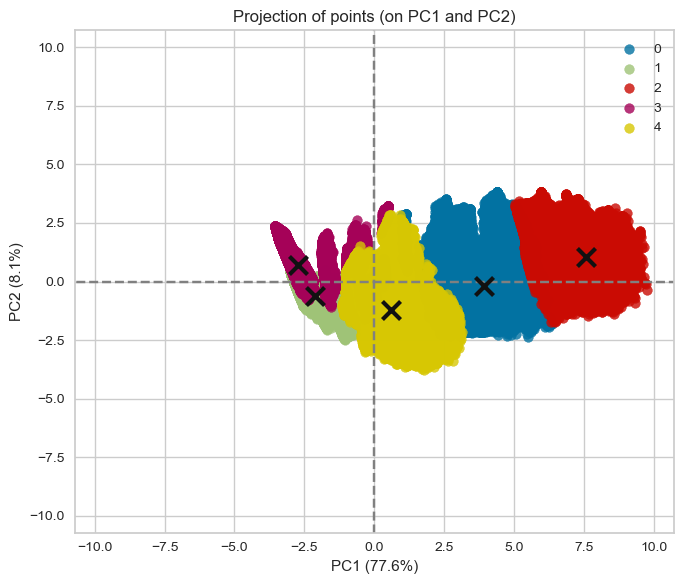

In [249]:
display_factorial_planes(reduced_features, 3, pca, [(0,1)], illustrative_var = clustering_df['cluster'], alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=3,
            color='k', zorder=10)
plt.tight_layout()
plt.savefig("Graphs/PCA_two_dimensions_5Means.png", dpi=500)
plt.show()

With PCA visualization, it appears that some of the clusters are not very different from each other, but placed on a continuum (as one would expect from geographical data with datapoints physically close one another). 
It does not seem like using k=3 or k=5 makes a big difference to separate clusters, although k=5 seems to overlap two clusters more. 

### Different method for visualization (from PCA to t-SNE), and using elbow method
Based on Tamijd Ahsan's tutorial and the official YellowBrick package.

In [250]:
X_segmentation = clustering_df[['altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI']]

In [251]:
model = KMeans(random_state = 25)

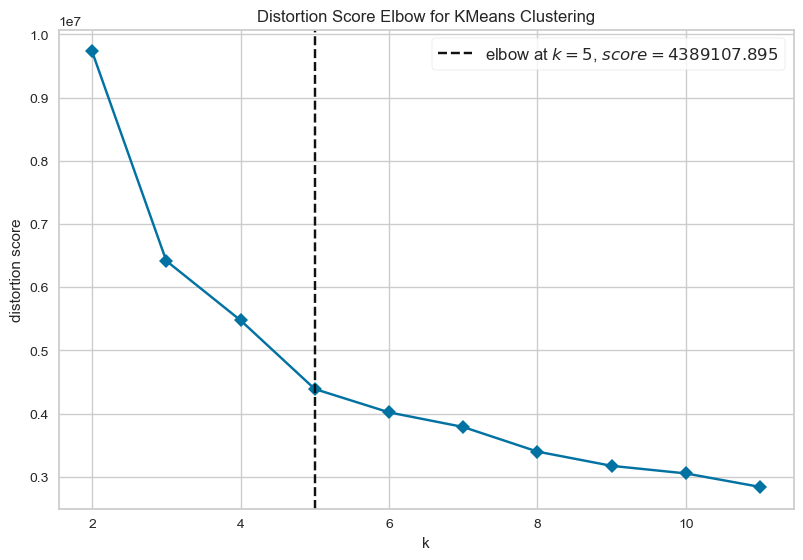

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [252]:
visualizer = KElbowVisualizer(model, k=(2,12), timings=False)  # Metric named "Distortion" = "sum of squared distances from each point to its assigned center"
visualizer.fit(X_segmentation) 
plt.tight_layout()
plt.savefig('Graphs/Elbow_score_kmeans.png', dpi = 500)
visualizer.show()

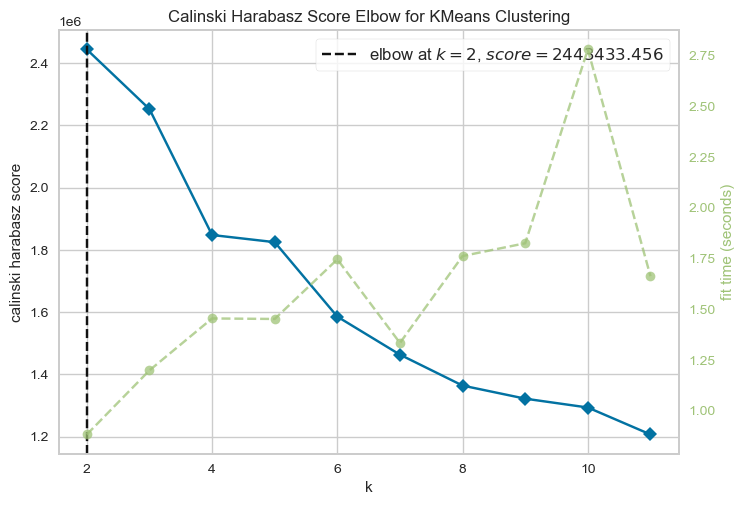

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [24]:
visualizer = KElbowVisualizer(model, k=(2,12), metric='calinski_harabasz', timings=False)  
# CH score is the ratio of the sum of between-cluster dispersion and of within-cluster dispersion.
visualizer.fit(X_segmentation) 
visualizer.show()

The two metric differences (sum of squared distances from cluster mean vs Calinski Hrabasz score) are not agreeing on which k is the best. The distance metric is euclidean in both. The CH seems to suggest, however, the worst number for K: 2 is almost meaningless. 

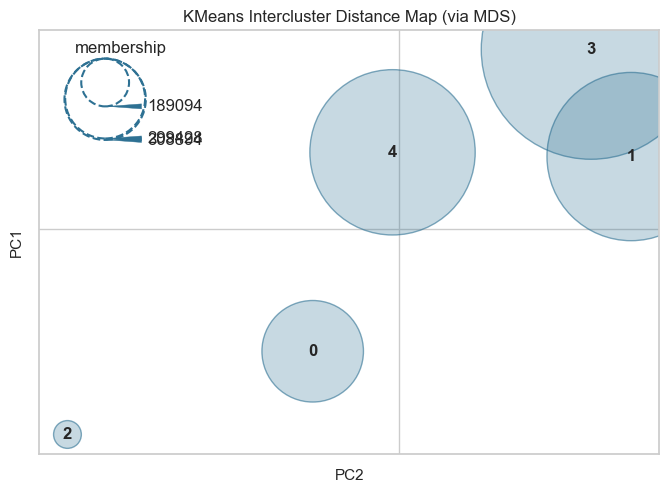

<Figure size 800x550 with 0 Axes>

In [254]:
#Using t-SNE

model = KMeans(5, random_state = 25)
intercluster_distance(model, embeddings='tsne',  # embedding 'tsne'
                                   random_state=25, 
                                   X = X_segmentation, legend_loc='upper left')    
#The results has the title "MDS" (multi-dimensional scaling) but that is because it's the default 
# title for this visualization and cannot be changed in the parameters  - I made sure to use t-SNE
plt.tight_layout()
plt.savefig('Graphs/Kmeans_intercluster_distancemap.png', dpi=500)

plt.show()

The results for the visualization are comparable (between sci-kit learn embedding the typical PCA and the yellowbrick package embedding t-SNE) for K=5 and seed 25, because: 

- clusters 1 and 3 are overlapped and sort of hard to separate even with t-SNE, although PCA is able to place cluster 4 away from the others, while PCA cannot.
- clusters 0 and 2 are more separable. 

In [256]:
subset_for_computing_purposes = clustering_df.sample(n=int(clustering_df.shape[0]*(1/6)), random_state=25) 
# 1 million and more than a half rows with 22 columns is not handled easily by KNN here
X = subset_for_computing_purposes[['altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI']]
y = subset_for_computing_purposes['cluster']

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=25)

### Using K-NN to see if 5 clusters' local structures can be learned

In [51]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)  
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on the testing set with 5 nearest neighbours: {accuracy}')

Accuracy on the testing set with 5 nearest neighbours: 0.9982417582417582


In [50]:
knn_classifier = KNeighborsClassifier(n_neighbors=50)  
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on the testing set with 50 nearest neighbours: {accuracy}')

Accuracy on the testing set with 50 nearest neighbours: 0.9972592113768585


In [54]:
knn_classifier = KNeighborsClassifier(n_neighbors=100)  
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on the testing set with 100 nearest neighbours: {accuracy}')

Accuracy on the testing set with 100 nearest neighbours: 0.9967420814479638


In [60]:
print("Classification Report:")
print(classification_report(y_test, y_pred))
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9210
           1       1.00      1.00      1.00     22950
           2       1.00      0.99      0.99      6515

    accuracy                           1.00     38675
   macro avg       1.00      1.00      1.00     38675
weighted avg       1.00      1.00      1.00     38675

Confusion Matrix
[[ 9151    33    26]
 [   18 22932     0]
 [   49     0  6466]]


**Interpretation**: theoretically, we can expect this high accuracy: since the clusters are identified based on the distance between data points with certain values of the parameters, there is not going to exist much "noise" in the clusters, as inside a certain radius from the centroid there's just going to be examples of a certain class. I just wanted to see what would happen.


Likely, the lack of assumptions of a general structure in the data makes K-NN perform very well at identifying the manifolds occupied in the parameter space to the point that fine-tuning K-NN seems not relevant (e.g. not much difference between k=3 and k=100). 

### Decision trees to interpret k-means
Using the X dataframe and y series that I produced in the KNN section (${1}/{6}$ of the whole data, and train/test split is $75/15$)

In [255]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans

In [258]:
kmeans = KMeans(n_clusters=5, random_state=25, n_init=20).fit(X)
y_kmeans = kmeans.predict(X)

In [259]:
centers_pred = kmeans.cluster_centers_
# print(centers_pred)

In [260]:
idx_pred_to_true = [0,4,3,2,1]
centers_pred[idx_pred_to_true,:]

array([[ 4.52438335e-01,  3.55723910e-03,  5.48137483e-01,
         6.06703819e-01,  7.78353792e-01,  6.24297500e-01,
         5.79056769e-01,  7.09721437e-01,  6.97292434e-01,
         7.11919236e-01,  7.20111911e-01,  8.44169498e-01,
         5.34491594e-01,  4.06220692e-01,  4.31650116e-01,
         4.55004083e-01,  4.14803804e-01,  5.52925475e-01,
         4.95298374e-01, -5.40576093e-01,  1.55618326e-03,
         4.76226356e-01,  6.71646604e-01, -4.47830866e-01,
         1.98830058e-01, -2.65807046e-01, -1.37165877e-01,
         2.12883416e-01,  4.88559669e-01,  4.85026592e-01],
       [ 5.69081268e-01,  5.96552868e-02,  5.90974725e-01,
         7.17607667e-01,  9.04494952e-01,  2.59446727e+00,
         1.79929149e+00,  1.21792171e+00,  1.23355478e+00,
         1.19440166e+00,  1.17013580e+00,  5.36601248e-01,
         1.26154224e+00,  9.51179212e-01,  9.50593480e-01,
         9.29143851e-01,  8.88669168e-01,  7.26868966e-01,
         1.29912234e+00, -6.90539174e-01,  1.21771218e-

In [261]:
clt = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_train, y_train)

In [262]:
y_pred = clt.predict(X_test)
acc    = accuracy_score(y_test,y_pred)
pre    = precision_score(y_test,y_pred,average='weighted')
rec    = recall_score(y_test,y_pred,average='weighted')
f1     = f1_score(y_test,y_pred,average='weighted')
print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')

Accuracy score: 0.9903
Precision score: 0.9904
Recall score: 0.9903
F1 score: 0.9903


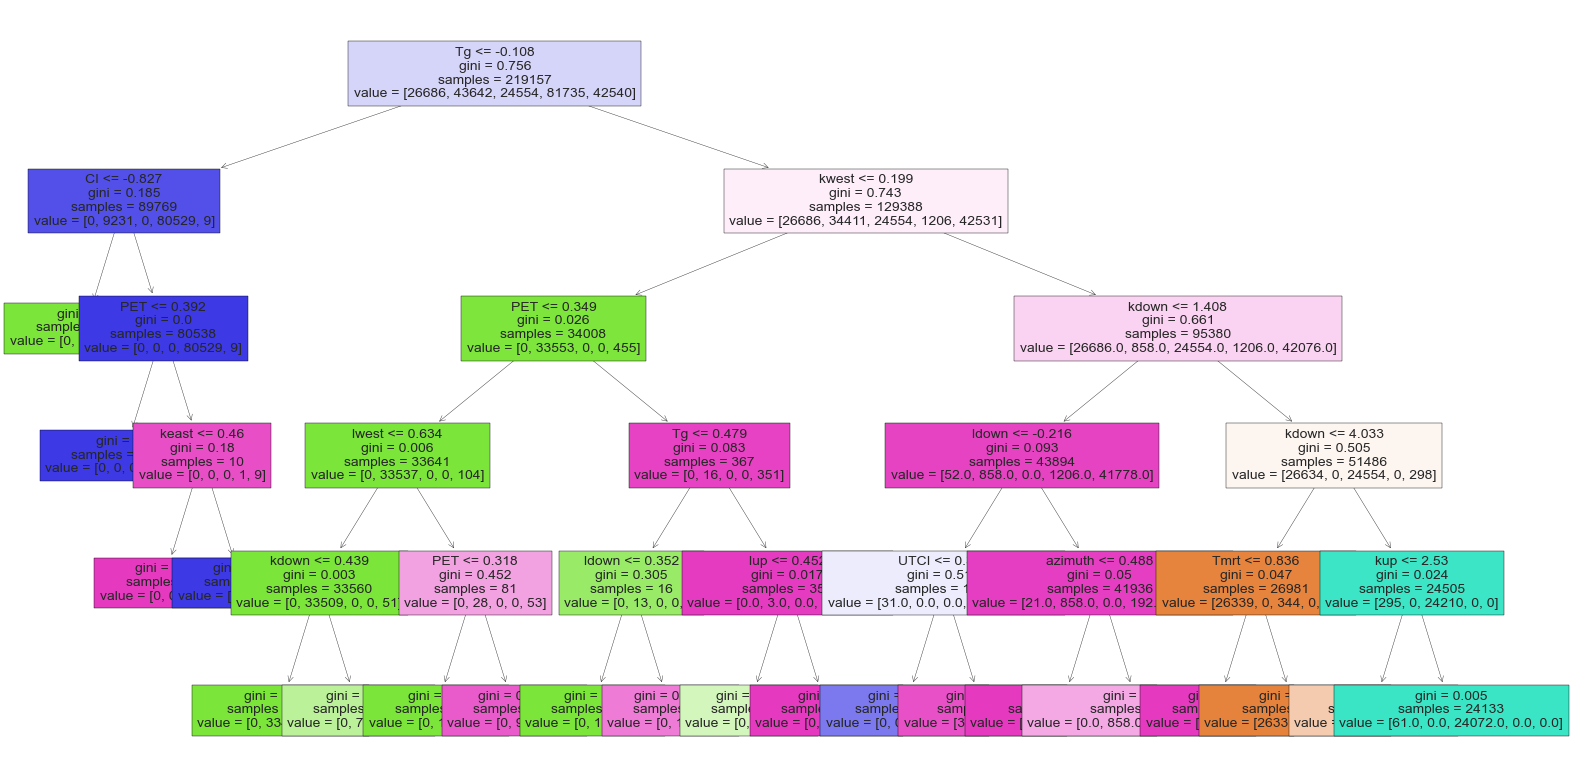

In [263]:
fig = plt.figure(figsize=(16,8))
_ = plot_tree(clt, 
              feature_names=X_test.columns,
              label='all',
              filled=True,
              fontsize=10)
plt.tight_layout()
plt.savefig('Graphs/decision_tree.png', dpi=500)

UTCI, kup, I0, Idown, are the variables that make a difference in the first three levels, and continue to help discern the data in the lower levels. But we need to check the features actually used in the construction of the tree (whose importance is not 0)

In [264]:
feature_importances = clt.feature_importances_

used_feature_indices = [i for i, importance in enumerate(feature_importances) if importance > 0]
used_feature_names = clustering_df.columns[used_feature_indices]

print(used_feature_names)
importances = feature_importances[used_feature_indices] 
vis_importance = dict()
print(vis_importance)
for i in range(len(used_feature_names)):
    vis_importance[used_feature_names[i]] = importances[i]
vis_importance = pd.DataFrame([vis_importance])
feature_importances = list(feature_importances)

Index(['it', 'kdiff', 'kglobal', 'kdown', 'keast', 'kwest', 'knorth', 'least',
       'lnorth', 'RH', 'Tmrt', 'SVF_bv', 'KsideI'],
      dtype='object')
{}


In [34]:
feature_importances.sort()
feature_importances.reverse()

In [35]:
sum(feature_importances[:4])

0.9893627411223359

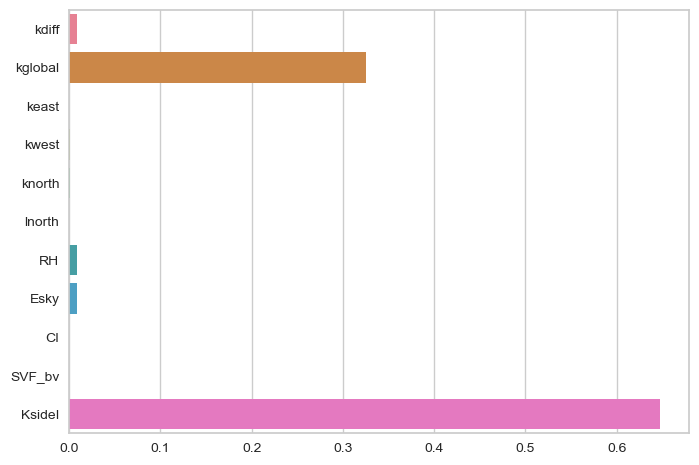

In [36]:
import warnings   #there are some verbose warnings about the handling of the data

vis_importance
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.barplot(vis_importance, orient='h')
    plt.show()

This tree had 99.5% accuracy to identify a k-means cluster on a sample of the data with 257,832 examples. But upon changing the seed for splitting into training and testing, the results change (none of the variables in the top levels are the same!).

In [265]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [266]:
random_forest_clf = RandomForestClassifier(n_estimators=10, random_state=25)
random_forest_clf = random_forest_clf.fit(X_train, y_train)

In [269]:
subset_for_computing_purposes = clustering_df.sample(n=int(clustering_df.shape[0]*(1/3)), random_state=25) 
# 1 million and more than a half rows with 22 columns is not handled easily by KNN here
X = subset_for_computing_purposes[['altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI']]
y = subset_for_computing_purposes['cluster']

scores = cross_val_score(random_forest_clf, X, y, cv=10)    #10 fold cross validation on more data (instead of 1/6 of the dataset, it's 1/3)
scores.mean()  #more info on these metrics https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

0.9990478298425826

Now, for the feature importance (based on mean decrease in node impurity):

In [293]:
feature_importances = random_forest_clf.feature_importances_

# Create a DataFrame to associate feature names with their importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)


In [306]:
importance_df.index

Index(['RH', 'Tmrt', 'PET', 'CI', 'altitude', 'Ta', 'kdown', 'lup', 'UTCI',
       'knorth', 'KsideI', 'azimuth', 'Tg', 'ldown', 'keast', 'kup', 'ksouth',
       'kwest', 'kglobal', 'I0', 'lwest', 'least', 'lsouth', 'lnorth',
       'Shadow', 'SVF_b', 'SVF_bv', 'Esky', 'kdir', 'kdiff'],
      dtype='object', name='Feature')

In [286]:
importance_df.set_index('Feature', inplace=True)  

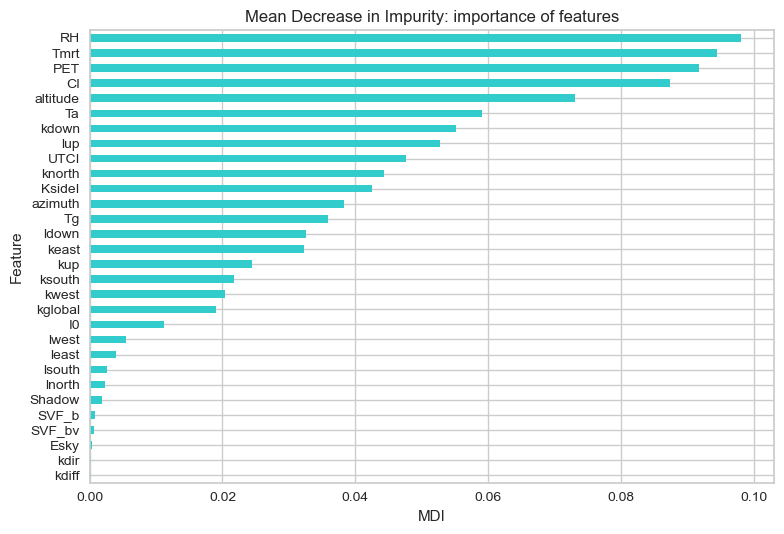

In [302]:
fig, ax = plt.subplots()

importance_df.plot.barh(ax=ax, color='#33cccc')   
ax.invert_yaxis()
ax.set_title("Mean Decrease in Impurity: importance of features")
ax.set_xlabel("MDI")
fig.tight_layout()
ax.legend().set_visible(False)
plt.savefig('Graphs/Feature_importance_random_forest.png', dpi=500)
plt.show()

#### Results and interpretation
- Using Random Forests that had a cross validated mean score of 0.998 on 515,664 examples, we find that some features are better at discerning the data than others. 
- The features used more for fitting trees were: **kup, ta, Trmt, kdown, UTCI, altitude, RH, lwest** (others had importance less than 5%).
- Extended name of the features: outgoing shortwave radiation (kup), air temperature from meteorological data (ta), mean radiant temperature (Trmt), incoming shortwave radiation (kdown), universal thermal comfort index (UTCI), altitude, relative humidity from meteorological data (RH), incoming longwave radiation (lwest)

### DBSCAN: density based clustering algorithm for arbitrary shapes
From Wikipedia, the Density-Based Spatial Clustering of Applications with Noise can be abstracted with:

- Find the points in the ε (eps) neighborhood of every point, and identify the core points with more than minPts neighbors.
- Find the connected components of core points on the neighbor graph, ignoring all non-core points.
- Assign each non-core point to a nearby cluster if the cluster is an ε (eps) neighbor, otherwise assign it to noise.

*Source: Schubert, Erich; Sander, Jörg; Ester, Martin; Kriegel, Hans Peter; Xu, Xiaowei (July 2017). "DBSCAN Revisited, Revisited: Why and How You Should (Still) Use DBSCAN". ACM Trans. Database Syst. 42 (3): 19:1–19:21. doi:10.1145/3068335. ISSN 0362-5915. S2CID 5156876.*

There are several advantages, and in our case the top two are that it can find **arbitrarly shaped** clusters, and **we don't need to indicate a number k** of clusters a-priori - which seems to be the case for data representing a small geographical region. However, the results are *not necessarily deterministic and depend on the distance measure*, and more disadvantages. 

From sci-kit learn: "DBSCAN - Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density."

In [311]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

#### Setting the hyperparameters: 

In [307]:
# minPts = minimum number of nearest samples for a point to be considered a core point: 
# it is recommended as equal or bigger to the number of dimensions in the data plus one. So I'll set it equal. 
MinPts = 30 + 1

In [81]:
# epsilon = the maximum distance between two samples for one to be considered as in the neighborhood of the other:
# it should be found using a k-distance plot - and the amount of data should be reduced due to its size! 
# this part is based on Tara Mullin's tutorial
subset_for_computing_purposes = clustering_df.sample(n=int(clustering_df.shape[0]*(1/100)), random_state=25) #1/10th of the data made my kernel die with DBSCAN.

X = subset_for_computing_purposes[['altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI']]

In [82]:
neighbors = NearestNeighbors(n_neighbors=MinPts) #I set it as the MinPt
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

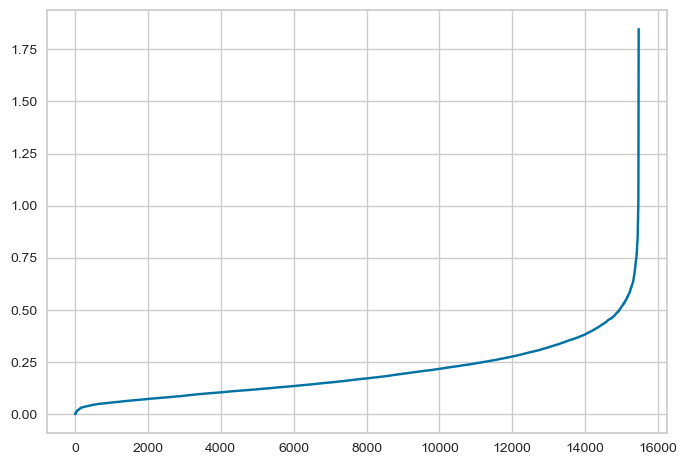

In [83]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

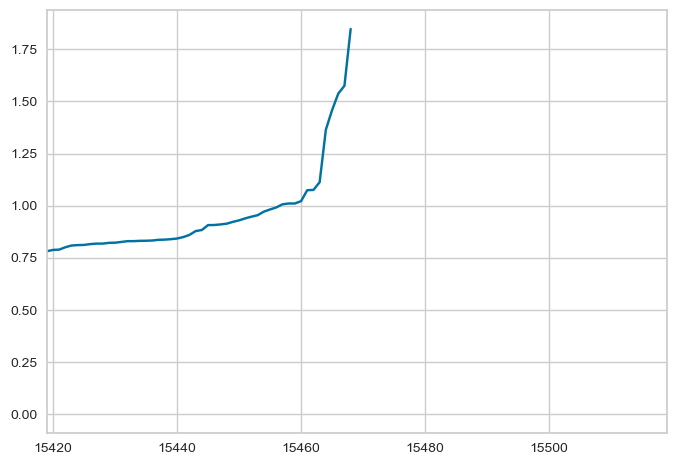

In [84]:
plt.plot(distances)
plt.xlim(left=X.shape[0]-50, right=X.shape[0]+50)
plt.show()

In [85]:
X.shape[0]

15469

It looks like the elbow appears around at the length of the data sample. Even when the sample was 1/10th of the data, the elbow placement followed the same pattern. But this cannot be the maximum distance for one to be considered neighbours of the other! Since my device (16 GB RAM) cannot have it as a distance. This way of estimating is not working in my case. Sci-kit learns also indicates that "The worst case memory complexity of DBSCAN is $O({n}^2)$, which can occur when the eps param is large and min_samples is low." - which is exactly our case. 

**I do not have access to the skills of a competent domain expert on this type of data**, but I think that the number of possible clusters should be equal or less than the **number of streets or areas** with the same characteristics over the whole area, spread over 24 hours. 

Usually for clustering algorithms it's best to standardize the feature space, but with DBSCAN I noticed it produces more issues: the epsilon estimation that I will use is just not working and makes DBSCAN only find 1 cluster; but what I found to be working is to use the original parameter space, and only when visualizing I will standardize the features to apply PCA.

In [308]:
clustering_df_NOT_NORMALIZED = pd.read_parquet("clustering_df_NOT_NORMALIZED.parquet")[['altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI']]
X = clustering_df_NOT_NORMALIZED.sample(n=int(clustering_df_NOT_NORMALIZED.shape[0]*(1/100)), random_state=25)

Sanders et al., 1998 https://link.springer.com/article/10.1023/A:1009745219419 suggest this formula for experimenting with epsilon:

$epsilon = 2∗ (D− 1)$    _where D is the dimensions of the parameter space_

In [309]:
epsilon  = 2*(MinPts-1) 
epsilon

60

In [312]:
dbscan = DBSCAN(eps=epsilon, min_samples=MinPts, metric='euclidean', 
                metric_params=None, algorithm='auto', 
                leaf_size=30, p=None, n_jobs=None)

In [313]:
labels = dbscan.fit_predict(X)

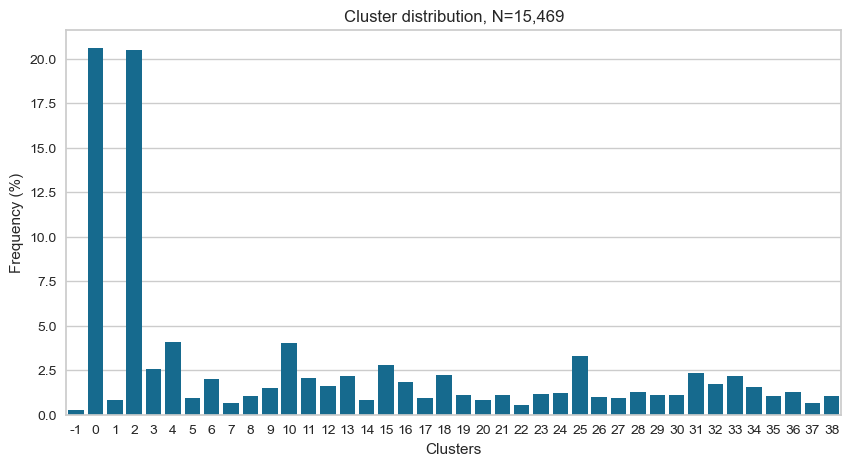

In [315]:
g0 = pd.DataFrame(labels)
y1 = g0.value_counts()
total_counts = y1.sum()
y1 = y1 / total_counts * 100

x2 = g0[0].value_counts().index

fig = plt.figure(figsize=(10, 5))

sns.barplot(y = y1, x=x2)
plt.title(f"Cluster distribution, N={X.shape[0]:,}")
plt.ylabel('Frequency (%)')
plt.xlabel('Clusters')
plt.savefig('Graphs/Cluster_distribution.png', dpi=500)
plt.show()

In [92]:
dbscan.get_params()

{'algorithm': 'auto',
 'eps': 60,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 31,
 'n_jobs': None,
 'p': None}

In [316]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 39
Estimated number of noise points: 41


In [318]:
clust_list = list(pd.DataFrame(labels)[0].unique())
clust_list.sort()
print(clust_list)  #39 clusters, and every disconnected observation is labelled -1. 

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]


In [319]:
g = X
#For visualization purposes with PCA, the clusters are now standardized 
scaler = RobustScaler()

for col in ['altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI' ]:   #all features but id and hour
    g[[f'{col}']] = scaler.fit_transform(g[[f'{col}']])

#PCA
pca = PCA(n_components=3)

reduced_features = pca.fit_transform(g[['altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI']])

reduced_g = pd.DataFrame(reduced_features, index=g.index, columns=['PC1','PC2', 'PC3'])
reduced_g['labels'] = labels
reduced_g.head()

PC1       PC2       PC3  labels
4  -2.603614  0.427775  0.370223       0
8   4.784493  2.277587 -0.272084       1
19 -2.342823 -0.630377 -1.169910       2
17 -1.263341 -1.487715 -0.602337       3
0  -2.968089  1.442743  0.218522       0

In [320]:
from mpl_toolkits.mplot3d import Axes3D
from colour import Color
from matplotlib.colors import ListedColormap

In [321]:
colors = list(Color('#2a92e8').range_to(Color("#e8862a"), len(clust_list[1:])))
colors = [str(color) for color in colors]
dark_grey = '#474747'  #for disconnected observations, labelled -1.
cmap_custom = ListedColormap(['#474747'] + colors)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


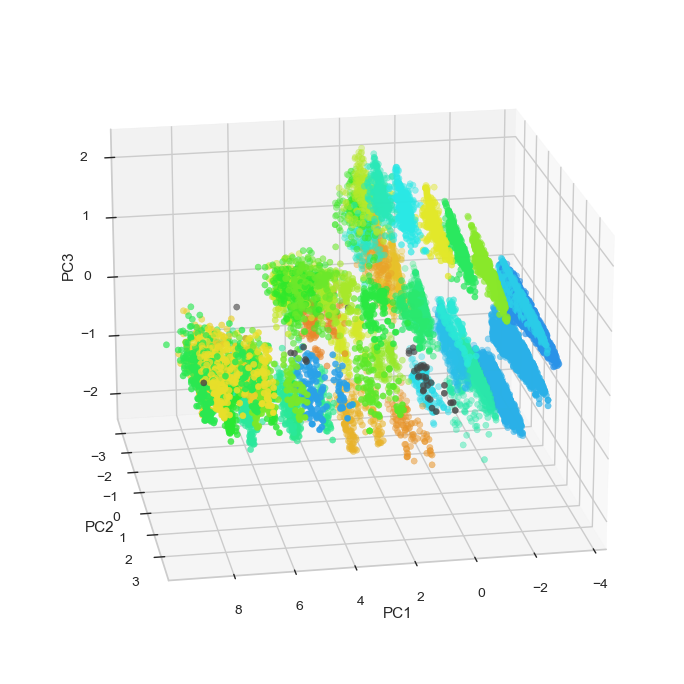

In [324]:

fig = plt.figure(figsize=(25, 7))
ax = fig.add_subplot(111, projection='3d')

xdata = reduced_g['PC1']
ydata = reduced_g['PC2']
zdata = reduced_g['PC3']

scatter = ax.scatter(xdata, ydata, zdata, c=reduced_g['labels'], cmap=cmap_custom)

ax.view_init(elev=20, azim=80)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3', rotation = 90)
plt.legend()
plt.savefig("Graphs/PCA_and_DBSCAN_clusters.png", dpi=500)
plt.show()

It is not extremely clear, but it appears as if observations of a certain cluster are horizontally distributed over what I believe is a principal component axis that greatly influenced by time as it is very linear. In terms of colors, how blue or how yellow of a cluster is does not matter, as the order in which the clusters are colored is not representative of anything - it's just to distinguish them. But we can see that some blue-er clusters are closer together, and some yellower clusters are closer together.

### Applying the findings from DBSCAN to K-means
Since DBSCAN does not work well with the amount of data presented, we can take the (possibly promising) findings to k-means and assume that, if the sample fed to DBSCAN was random enough, there are still around 39 clusters in the data with some outliers in them - and then assign to a cluster every observation from every cell we care about. 

In [325]:
clustering_df = pd.read_parquet("clustering_data.parquet")

In [326]:
final_kmeans = KMeans(n_clusters = 39, random_state=25)

clustering_df['cluster'] = final_kmeans.fit_predict(clustering_df[['altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI']])

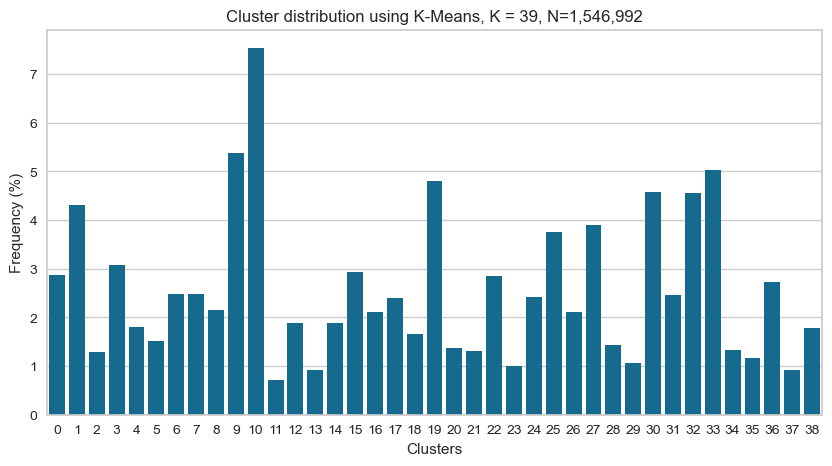

In [327]:
g0 = pd.DataFrame(clustering_df.cluster)
y1 = g0.value_counts()
total_counts = clustering_df.shape[0]
y1 = (y1 / total_counts) * 100

x2 = g0['cluster'].value_counts().index
fig = plt.figure(figsize=(10, 5))

sns.barplot(y = y1, x=x2)
plt.title(f"Cluster distribution using K-Means, K = 39, N={clustering_df.shape[0]:,}")
plt.ylabel('Frequency (%)')
plt.xlabel('Clusters')
plt.savefig('Graphs/Kmeans_distribution_k_39.png', dpi=1000)
plt.show()

The distribution is somewhat similar: there seem to be some clusters within the clusters, but the main difference with the DBSCAN results is that there are no clusters with more than 20% of the observations in the sample.

In [100]:
print(f"On average, a cluster holds {(g0.value_counts().sum()/39)/clustering_df.shape[0]*100:.2f}% of the whole distribution, although several clusters are not similar to the average.")

On average, a cluster holds 2.56% of the whole distribution, although several clusters are not similar to the average.


In [336]:
pca = PCA(n_components=3)

reduced_features = pca.fit_transform(clustering_df[['altitude', 'azimuth', 'kdir', 'kdiff', 'kglobal', 'kdown',
       'kup', 'keast', 'ksouth', 'kwest', 'knorth', 'ldown', 'lup', 'least',
       'lsouth', 'lwest', 'lnorth', 'Ta', 'Tg', 'RH', 'Esky', 'Tmrt', 'I0',
       'CI', 'Shadow', 'SVF_b', 'SVF_bv', 'KsideI', 'PET', 'UTCI']])

pca_df = pd.DataFrame(reduced_features, index=clustering_df.index, columns=['PC1','PC2','PC3'])
pca_df['labels'] = clustering_df['cluster']
pca_df.head(2)

PC1       PC2       PC3  labels
-1 -2.773857  0.499758  0.402729       9
 0 -2.836680  0.938923 -0.404175      10

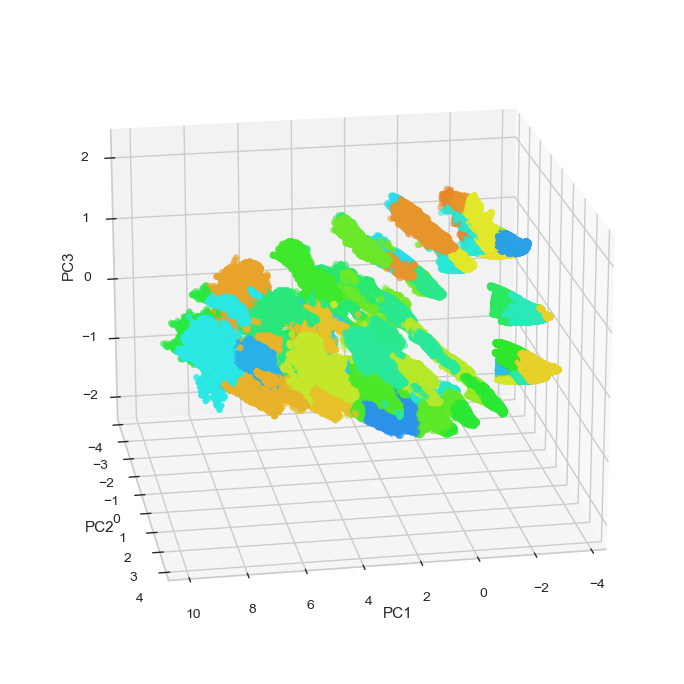

In [337]:
fig = plt.figure(figsize=(25, 7))
ax = fig.add_subplot(111, projection='3d')

xdata = pca_df['PC1']
ydata = pca_df['PC2']
zdata = pca_df['PC3']

scatter = ax.scatter(xdata, ydata, zdata, c=pca_df['labels'], cmap=ListedColormap(colors))

ax.view_init(elev=20, azim=80)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3', rotation = 90)
plt.tight_layout()
plt.savefig("Graphs/PCA_and_Kmeans_clusters.png", dpi=500)
plt.show()

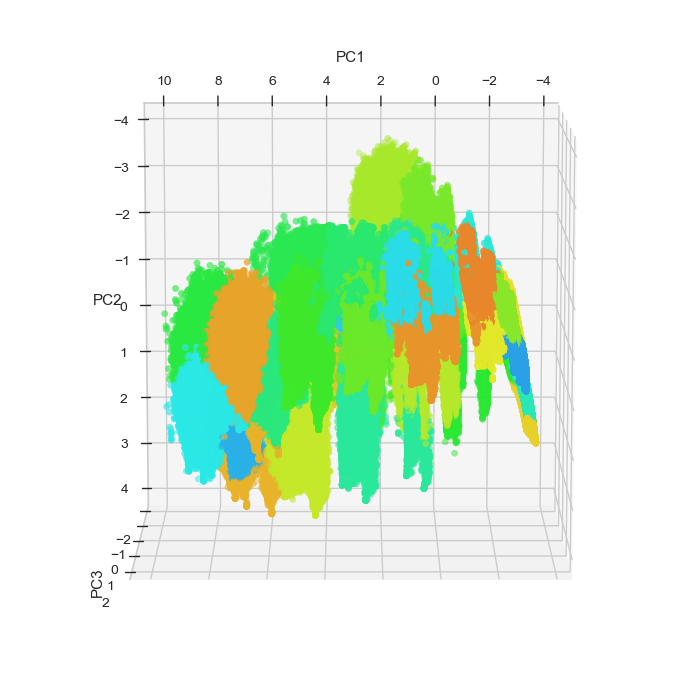

In [339]:
fig = plt.figure(figsize=(25, 7))
ax = fig.add_subplot(111, projection='3d')

xdata = pca_df['PC1']
ydata = pca_df['PC2']
zdata = pca_df['PC3']

scatter = ax.scatter(xdata, ydata, zdata, c=pca_df['labels'], cmap=ListedColormap(colors))

ax.view_init(elev=100, azim=90)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3', rotation = 90)
plt.tight_layout()
plt.savefig("Graphs/PCA_and_Kmeans_clusters_from_above.png", dpi=500)
plt.show()

It looks very similar to the clusterization from DBSCAN. Good job k-means!

In [107]:
clustering_df[['id', 'cluster', 'it']].to_parquet('clustering_results.parquet')

# Objective #5. Data Analysis.
- Describe three main types of hour differences during daylight in the data (e.g. early morning, midday, afternoon).
1. Intersect PET grid (dataset 1) and land use
2. Compute distribution of land usage for each cluster
3. Visualize data using pie charts.

The first point requires fixing the geometries, as both QGIS and geopandas have the same results (some geometries in land use are just broken) and performing intersection either does not finish executing or does not compile at all, depending on the methods I tried (using gpd's _intersect_ method or QGIS's _intersection_ algorithm). Fixing the geometries occurs below:

In [3]:
clustering_results = pd.read_parquet("clustering_results.parquet")
clustering_results.loc[:, 'id'] = clustering_results.loc[:,'id'].astype(int)

In [3]:
grid_hourlyPET = gpd.read_file("Dataset 1/populated with data/GRID_POI_CC_Milan_5m_hourlyPET.shp")

In [4]:
land_use = gpd.read_file("Dataset 3/UDS_ClimateComfort_ALL_FullTopology_NoOverlap.shp")

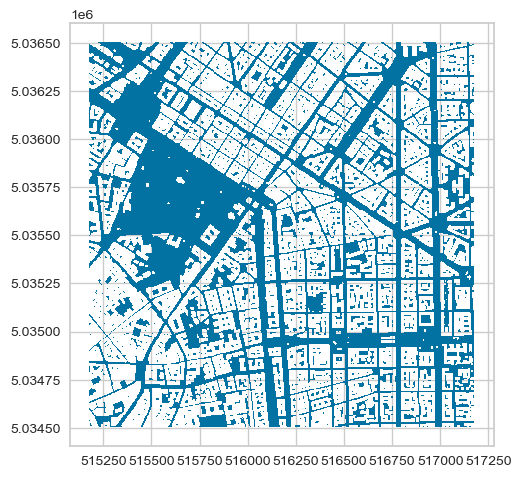

In [5]:
grid_hourlyPET.plot()
plt.show()

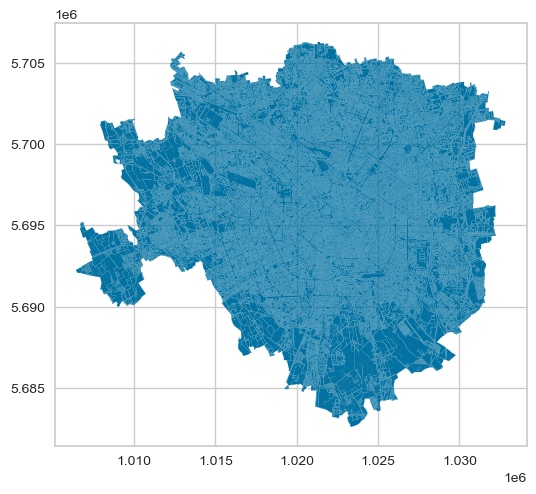

In [6]:
land_use.plot()
plt.show()

In [7]:
land_use.head(5)

Type  COD raster  \
0                 Paved           1   
1              Building           2   
2                 Grass           5   
3                 Paved           1   
4  Deciduous vegetation           4   

                                            geometry  
0  MULTIPOLYGON Z (((1012679.545 5704856.360 48.3...  
1  MULTIPOLYGON Z (((1019839.736 5706073.990 73.2...  
2  MULTIPOLYGON Z (((1021685.997 5706108.363 0.00...  
3  MULTIPOLYGON Z (((1020545.694 5706250.772 72.8...  
4  MULTIPOLYGON Z (((1021774.267 5706093.014 72.0...

In [8]:
print(land_use.crs, grid_hourlyPET.crs)  #oop! they're different.

EPSG:3857 EPSG:32632


In [9]:
land_use = land_use.to_crs(grid_hourlyPET.crs)

In [10]:
print(land_use.crs, grid_hourlyPET.crs) 

EPSG:32632 EPSG:32632


In [11]:
validity = land_use.geometry.is_valid 
print(validity)   #some geometries need fixing.

to_fix = []
for i in range(len(validity)):
    if not validity.iloc[i]:
        to_fix.append(i)

0      True
1      True
2     False
3     False
4      True
5     False
6      True
7     False
8     False
9     False
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
25     True
26     True
27     True
28    False
29    False
30     True
31     True
32     True
33     True
34     True
35     True
36     True
37     True
38     True
39     True
40     True
41     True
42     True
43     True
dtype: bool


In [ ]:
import time
for i in to_fix:
    start_time = time.time()
    land_use.loc[i, 'geometry'] = land_use.geometry[i].buffer(0, resolution=1)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"object {i} required {elapsed_time//60} minutes and {round(elapsed_time%60)} seconds.")

In [ ]:
land_use.geometry.is_valid 

In [ ]:
land_use.to_file("Dataset 3/fixed version/UDS_ClimateComfort_ALL_FullTopology_NoOverlap.shp")   #just in case

I went on to QGIS to intersect the PET grid, land use and trees (I do not know why but out of all the attempts I did on Python it seemed like it would never finish executing the gpd.intersection command, even after cleaning).  The trees come from a polygonization of the .tif file (which displayed different intensities of trees coverage), which created 5x5 cells representing trees and attributing a value with respect to the original value.

I selected only the part of "land_use" that overlays with the same positions as the grid (to reduce the total amount ofcomputation 
required to intersect and then I did intersect them. 

It is the first time I use QGIS extensively, and it took my device several hours just to intersect the two sets of geometries - which makes me wonder if there are some time efficient ways. 

In [4]:
stat_df = gpd.read_file("Dataset 3/Subset/Intersection_LANDUSE_GRIDPET.shp")

In [5]:
trees = gpd.read_file("Dataset 3/Subset/GRIDPET_TREES.shp")

<Axes: >

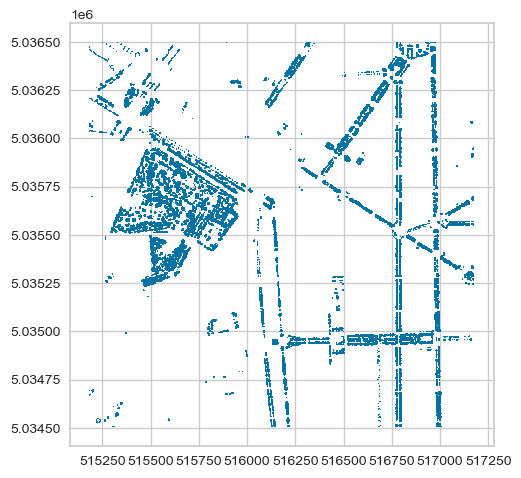

In [6]:
trees.plot()

#### Cleaning trees dataset

In [7]:
trees = trees[['id', 'VALUE']]
trees.rename(columns={'VALUE':'Tree'},inplace=True)
trees.loc[:,'Tree'] = [0 if t == 'nan' else round(float(t)) for t in trees.Tree.astype(str)]

/tmp/ipykernel_112182/1191925843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trees.rename(columns={'VALUE':'Tree'},inplace=True)


In [8]:
print(trees.id.unique().shape[0])
trees = trees[trees.id.isin(clustering_results.id.unique())]   #I'll only select the cells that could match clustering results.
print(trees.id.unique().shape[0])

27175
25363


In [9]:
print(trees.id.shape[0])  #There are too many observations for each cell. I will have to group them.
trees = trees.groupby('id')['Tree'].median().reset_index()

128969


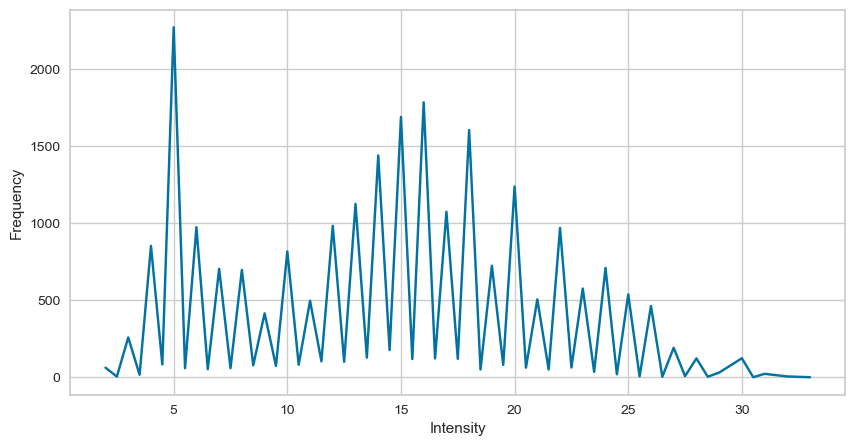

In [351]:
fig = plt.figure(figsize=(10, 5))

fig.add_subplot(111)
ax= trees.Tree.value_counts().sort_index().head(60).plot()
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')

plt.savefig('Graphs/tree_value_counts.png', dpi=500)

In [11]:
print(stat_df.shape[0])
print('Unique cells:', stat_df.id.unique().shape[0])
print() 
stat_df.head() 

149745
Unique cells: 67053



Type  COD raster       id BUILDING  ID_GRID     h0     h1     h2     h3  \
0  Grass         5.0  7944939     None       43  17.61  18.57  18.60  18.07   
1  Grass         5.0  7944940     None       43  17.75  18.75  18.79  18.26   
2  Grass         5.0  7944941     None       43  17.81  18.81  18.86  18.32   
3  Grass         5.0  7944942     None       43  17.99  19.02  19.10  18.55   
4  Grass         5.0  7944943     None       43  18.32  19.42  19.54  18.97   

      h4  ...    h15    h16    h17    h18    h19    h20    h21    h22    h23  \
0  17.33  ...  46.59  46.70  39.17  32.89  28.70  22.52  20.50  19.53  18.24   
1  17.52  ...  46.32  46.55  39.09  32.95  28.80  22.66  20.68  19.68  18.36   
2  17.58  ...  44.07  44.19  37.44  31.86  28.00  22.04  20.71  19.71  18.38   
3  17.81  ...  44.03  44.16  37.44  31.89  28.12  22.24  20.92  19.89  18.53   
4  18.22  ...  44.19  44.35  37.57  32.11  28.45  22.62  21.32  20.28  18.82   

                                            geometry  
0  MULTIPOLYGON Z (((1023506.822 5697121.923 0.00...  
1  POLYGON Z ((1023505.917 5697111.181 0.000, 102...  
2  POLYGON Z ((1023506.789 5697108.485 10.751, 10...  
3  POLYGON Z ((1023506.772 5697101.340 10.751, 10...  
4  POLYGON Z ((1023506.755 5697094.195 10.751, 10...  

[5 rows x 30 columns]

I will merge the trees and the intersection dataframe between land use and the PET grid.

In [12]:
stat_df = stat_df.merge(trees, on='id', how='inner')
print(stat_df.shape[0])
stat_df.head()

59322


Type  COD raster       id BUILDING  ID_GRID     h0     h1     h2     h3  \
0  Grass         5.0  7944941     None       43  17.81  18.81  18.86  18.32   
1  Grass         5.0  7944942     None       43  17.99  19.02  19.10  18.55   
2  Grass         5.0  7944943     None       43  18.32  19.42  19.54  18.97   
3  Grass         5.0  7944944     None       43  18.40  19.52  19.64  19.07   
4  Grass         5.0  7944945     None       43  18.55  19.71  19.86  19.28   

      h4  ...    h16    h17    h18    h19    h20    h21    h22    h23  \
0  17.58  ...  44.19  37.44  31.86  28.00  22.04  20.71  19.71  18.38   
1  17.81  ...  44.16  37.44  31.89  28.12  22.24  20.92  19.89  18.53   
2  18.22  ...  44.35  37.57  32.11  28.45  22.62  21.32  20.28  18.82   
3  18.32  ...  44.01  37.48  32.11  28.49  22.69  21.41  20.39  18.89   
4  18.53  ...  33.18  30.30  32.13  28.58  22.84  21.61  20.60  19.03   

                                            geometry  Tree  
0  POLYGON Z ((1023506.789 5697108.485 10.751, 10...  15.0  
1  POLYGON Z ((1023506.772 5697101.340 10.751, 10...  14.0  
2  POLYGON Z ((1023506.755 5697094.195 10.751, 10...  14.0  
3  POLYGON Z ((1023506.738 5697087.050 10.751, 10...  14.0  
4  POLYGON Z ((1023506.721 5697079.905 10.751, 10...  14.0  

[5 rows x 31 columns]

Now I have to merge the **clustering results** with the intersection dataframe. This is problematic because I clustered with respect to the hour to obtain hour-specific results, hence there are multiple identically named cells in this dataframe, but I want to simply assign three cluster results for each cell, also in compliance with TT's indications. As a result, I will assign to each cell the cluster it was mostly attributed to (the statistical mode) throughout the day phases (early morning and morning, midday, early and late afternooon), and use those as the cluster for the intersection. 

The other solution could've been creating 24 columns in the intersection representing the clusters that the cell belonged to throughout the day, but I don't think it would've simplified the analysis enough and time is a resource that is scarce during the exam session.

In [13]:
morning = [7,8,9,10,11]
midday = [12, 13, 14]
afternoon = [15, 16, 17,18,19]

In [14]:
# Baby example to clarify:
clustering_results[(clustering_results.id == 7945218) & (clustering_results.it.isin(morning))] 
# the most common cluster is 22 so it will be picked.

id  cluster    it
5  7945218.0       10   7.0
6  7945218.0       18   8.0
7  7945218.0       22   9.0
8  7945218.0       22  10.0
9  7945218.0       21  11.0

In [15]:
morning_clustering_results = clustering_results[clustering_results.it.isin(morning)].groupby('id')['cluster'].apply(lambda x: x.mode().iloc[0]).reset_index()
morning_clustering_results.rename(columns={'cluster':'cl_morni'}, inplace=True)
morning_clustering_results.head()

id  cl_morni
0  7941545.0        22
1  7941546.0        18
2  7941547.0        18
3  7941548.0        18
4  7941549.0        18

In [16]:
morning_clustering_results.shape[0]

64458

In [17]:
morning_clustering_results[morning_clustering_results.id == 7945218] 

id  cl_morni
244  7945218.0        22

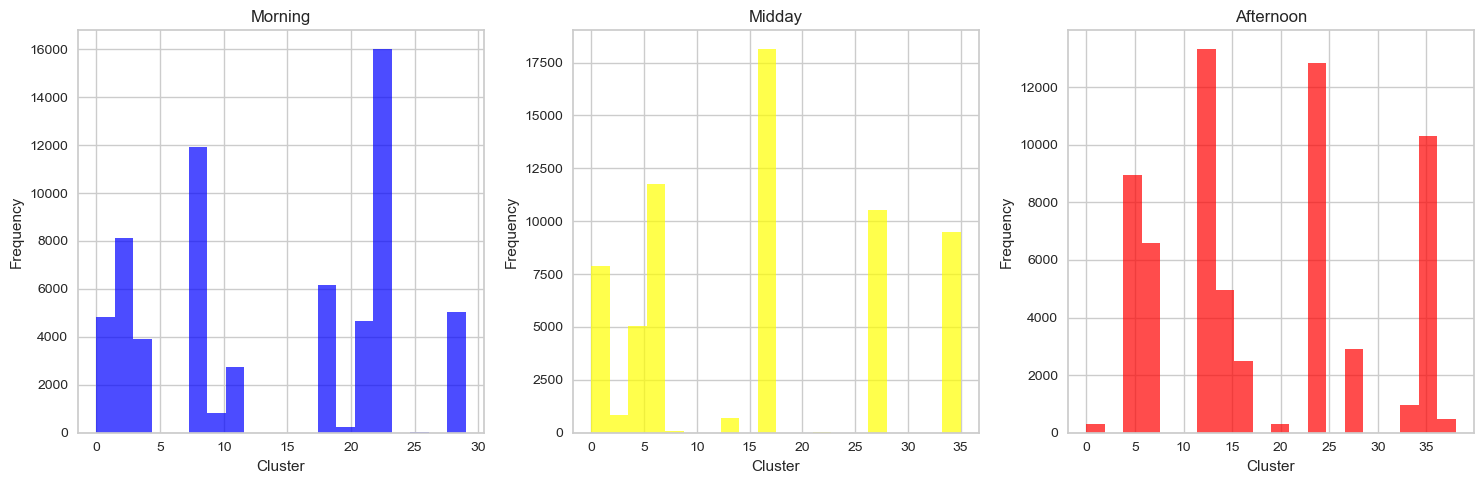

In [18]:
# doing the rest and concatenating it:
midday_clustering_results = clustering_results[clustering_results.it.isin(midday)].groupby('id')['cluster'].apply(lambda x: x.mode().iloc[0]).reset_index()
midday_clustering_results.rename(columns={'cluster':'cl_midda'}, inplace=True)

afternoon_clustering_results = clustering_results[clustering_results.it.isin(afternoon)].groupby('id')['cluster'].apply(lambda x: x.mode().iloc[0]).reset_index()
afternoon_clustering_results.rename(columns={'cluster':'cl_after'}, inplace=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
morning_clustering_results['cl_morni'].hist(ax=axes[0], bins=20, color='blue', alpha=0.7)
axes[0].set_title('Morning')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Frequency')

midday_clustering_results['cl_midda'].hist(ax=axes[1], bins=20, color='yellow', alpha=0.7)
axes[1].set_title('Midday')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Frequency')

afternoon_clustering_results['cl_after'].hist(ax=axes[2], bins=20, color='red', alpha=0.7)
axes[2].set_title('Afternoon')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [19]:
test_clustering_results = morning_clustering_results.merge(midday_clustering_results, on='id', how='inner')
test_clustering_results = test_clustering_results.merge(afternoon_clustering_results, on='id', how='inner')
test_clustering_results.head()

id  cl_morni  cl_midda  cl_after
0  7941545.0        22         6        36
1  7941546.0        18         6        36
2  7941547.0        18         6        36
3  7941548.0        18         6        36
4  7941549.0        18         6        36

In [20]:
print(stat_df.id.unique().shape[0])
print(test_clustering_results.id.unique().shape[0])

25363
64458


In [368]:
df = stat_df.merge(test_clustering_results, on ='id', how='inner')[['id','Type', 'Tree', 'building'.upper(), 
                                                                      'h7','h8','h9','h10',
                                                                      'h11','h12','h13','h14',
                                                                      'h15', 'h16', 'h17','h18','h19',
                                                                      'cl_morni', 'cl_midda','cl_after','geometry', 
                                                                     ]]
df

id     Type  Tree BUILDING     h7     h8     h9    h10    h11  \
0      7944941    Grass  15.0     None  18.75  21.26  23.35  25.23  27.59   
1      7944942    Grass  14.0     None  19.05  21.47  23.49  25.41  27.61   
2      7944943    Grass  14.0     None  19.60  21.90  23.84  25.70  27.72   
3      7944944    Grass  14.0     None  19.74  22.00  23.92  25.79  27.78   
4      7944945    Grass  14.0     None  20.02  22.21  24.22  26.12  28.13   
...        ...      ...   ...      ...    ...    ...    ...    ...    ...   
59317  8899365  polygon  18.0     None  20.79  22.89  24.59  38.35  34.04   
59318  8899366  polygon  20.0     None  20.65  22.79  24.53  26.50  39.36   
59319  8899367  polygon  20.0     None  20.59  22.82  24.70  26.74  28.85   
59320  8899368  polygon  20.0     None  20.29  22.59  24.53  26.70  41.05   
59321  8899370  polygon  20.0     None  19.93  22.28  35.90  26.89  28.73   

         h12  ...    h14    h15    h16    h17    h18    h19  cl_morni  \
0      36.29  ...  38.82  44.07  44.19  37.44  31.86  28.00        18   
1      36.25  ...  38.75  44.03  44.16  37.44  31.89  28.12        18   
2      36.37  ...  38.78  44.19  44.35  37.57  32.11  28.45        22   
3      30.46  ...  33.21  33.37  44.01  37.48  32.11  28.49        22   
4      30.83  ...  33.28  33.55  33.18  30.30  32.13  28.58         8   
...      ...  ...    ...    ...    ...    ...    ...    ...       ...   
59317  37.30  ...  39.42  39.31  39.02  34.23  29.97  24.98         8   
59318  43.28  ...  39.81  39.71  39.32  34.24  29.93  24.91         8   
59319  45.15  ...  41.42  41.28  40.88  35.14  30.48  25.06         8   
59320  45.82  ...  47.74  41.97  41.21  35.19  30.39  24.91         2   
59321  31.71  ...  46.82  47.20  47.35  35.33  30.23  26.86         0   

       cl_midda  cl_after                                           geometry  
0            34        13  POLYGON Z ((1023506.789 5697108.485 10.751, 10...  
1            34        13  POLYGON Z ((1023506.772 5697101.340 10.751, 10...  
2            34        13  POLYGON Z ((1023506.755 5697094.195 10.751, 10...  
3             0        13  POLYGON Z ((1023506.738 5697087.050 10.751, 10...  
4             0        27  POLYGON Z ((1023506.721 5697079.905 10.751, 10...  
...         ...       ...                                                ...  
59317         4        14  POLYGON Z ((1025557.926 5697160.434 0.000, 102...  
59318         4        14  POLYGON Z ((1025557.907 5697153.289 0.000, 102...  
59319        16        16  POLYGON Z ((1025557.888 5697146.144 0.000, 102...  
59320        17        16  POLYGON Z ((1025557.869 5697138.999 0.000, 102...  
59321        17        36  POLYGON Z ((1025557.832 5697124.709 0.000, 102...  

[59322 rows x 21 columns]

I cannot really work anything out of the "polygon" type of land use, so I'll have to replace (many) observations with "Tree" for now. This is a choice based on the visualization of trees: they cover much of the non-building land. Take for reference the following figure made in QGIS: 
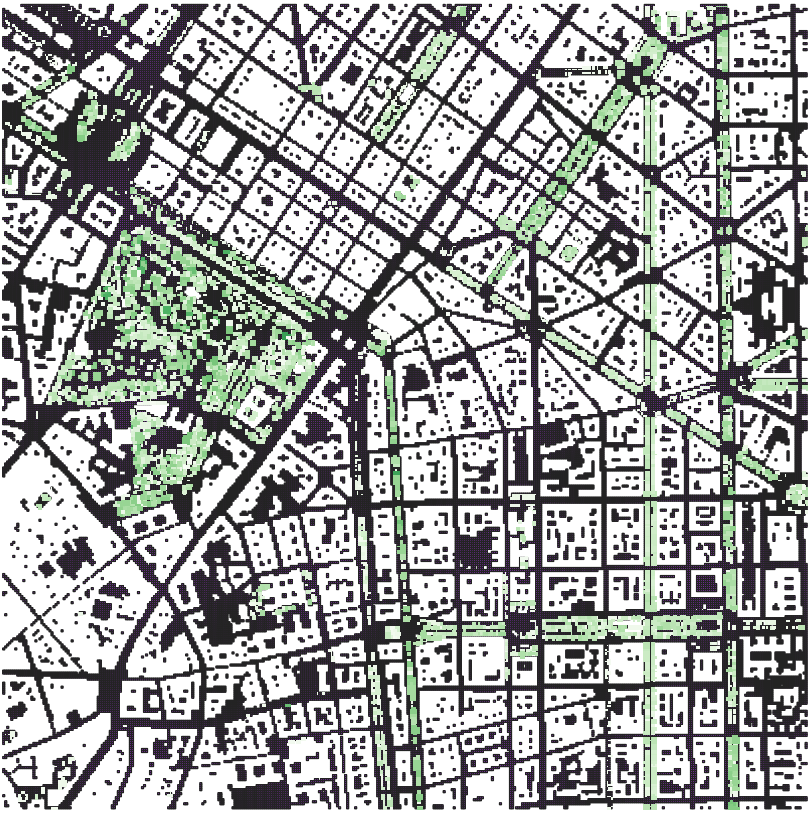

In green, trees. In dark purple, any land without buildings on it.

In [353]:
df.Type.value_counts()

Type
Tree canopy    25363
Paved          21728
Grass          11338
Water            491
Building         251
Bare soil        151
Name: count, dtype: int64

<Axes: >

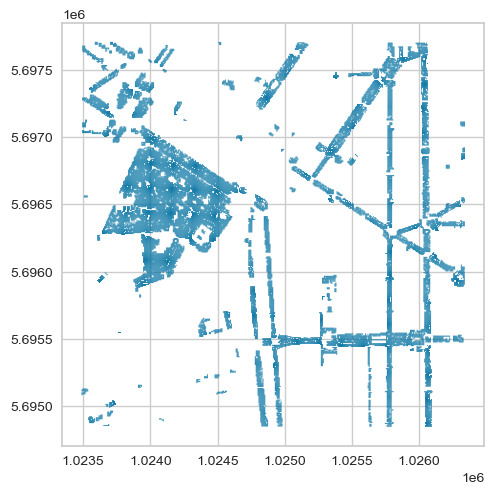

In [355]:
df[df.Type == 'Tree canopy'].plot()

In [24]:
df.loc[:, 'Type'] = ["Tree canopy" if t == 'polygon'  else t for t in df.Type]
df.Type.value_counts()

Type
Tree canopy    25363
Paved          21728
Grass          11338
Water            491
Building         251
Bare soil        151
Name: count, dtype: int64

In [25]:
df

id         Type  Tree BUILDING     h7     h8     h9    h10    h11  \
0      7944941        Grass  15.0     None  18.75  21.26  23.35  25.23  27.59   
1      7944942        Grass  14.0     None  19.05  21.47  23.49  25.41  27.61   
2      7944943        Grass  14.0     None  19.60  21.90  23.84  25.70  27.72   
3      7944944        Grass  14.0     None  19.74  22.00  23.92  25.79  27.78   
4      7944945        Grass  14.0     None  20.02  22.21  24.22  26.12  28.13   
...        ...          ...   ...      ...    ...    ...    ...    ...    ...   
59317  8899365  Tree canopy  18.0     None  20.79  22.89  24.59  38.35  34.04   
59318  8899366  Tree canopy  20.0     None  20.65  22.79  24.53  26.50  39.36   
59319  8899367  Tree canopy  20.0     None  20.59  22.82  24.70  26.74  28.85   
59320  8899368  Tree canopy  20.0     None  20.29  22.59  24.53  26.70  41.05   
59321  8899370  Tree canopy  20.0     None  19.93  22.28  35.90  26.89  28.73   

         h12  ...    h14    h15    h16    h17    h18    h19  cl_morni  \
0      36.29  ...  38.82  44.07  44.19  37.44  31.86  28.00        18   
1      36.25  ...  38.75  44.03  44.16  37.44  31.89  28.12        18   
2      36.37  ...  38.78  44.19  44.35  37.57  32.11  28.45        22   
3      30.46  ...  33.21  33.37  44.01  37.48  32.11  28.49        22   
4      30.83  ...  33.28  33.55  33.18  30.30  32.13  28.58         8   
...      ...  ...    ...    ...    ...    ...    ...    ...       ...   
59317  37.30  ...  39.42  39.31  39.02  34.23  29.97  24.98         8   
59318  43.28  ...  39.81  39.71  39.32  34.24  29.93  24.91         8   
59319  45.15  ...  41.42  41.28  40.88  35.14  30.48  25.06         8   
59320  45.82  ...  47.74  41.97  41.21  35.19  30.39  24.91         2   
59321  31.71  ...  46.82  47.20  47.35  35.33  30.23  26.86         0   

       cl_midda  cl_after                                           geometry  
0            34        13  POLYGON Z ((1023506.789 5697108.485 10.751, 10...  
1            34        13  POLYGON Z ((1023506.772 5697101.340 10.751, 10...  
2            34        13  POLYGON Z ((1023506.755 5697094.195 10.751, 10...  
3             0        13  POLYGON Z ((1023506.738 5697087.050 10.751, 10...  
4             0        27  POLYGON Z ((1023506.721 5697079.905 10.751, 10...  
...         ...       ...                                                ...  
59317         4        14  POLYGON Z ((1025557.926 5697160.434 0.000, 102...  
59318         4        14  POLYGON Z ((1025557.907 5697153.289 0.000, 102...  
59319        16        16  POLYGON Z ((1025557.888 5697146.144 0.000, 102...  
59320        17        16  POLYGON Z ((1025557.869 5697138.999 0.000, 102...  
59321        17        36  POLYGON Z ((1025557.832 5697124.709 0.000, 102...  

[59322 rows x 21 columns]

In [26]:
N_without_polygons = df.shape[0]
labels = df['Type'].unique()
labels = [ f'{s} ({ df[df['Type'] == s].shape[0] / N_without_polygons *100:.2f}%)' for s in labels]
labels.sort()
labels

['Bare soil (0.25%)',
 'Building (0.42%)',
 'Grass (19.11%)',
 'Paved (36.63%)',
 'Tree canopy (42.75%)',
 'Water (0.83%)']

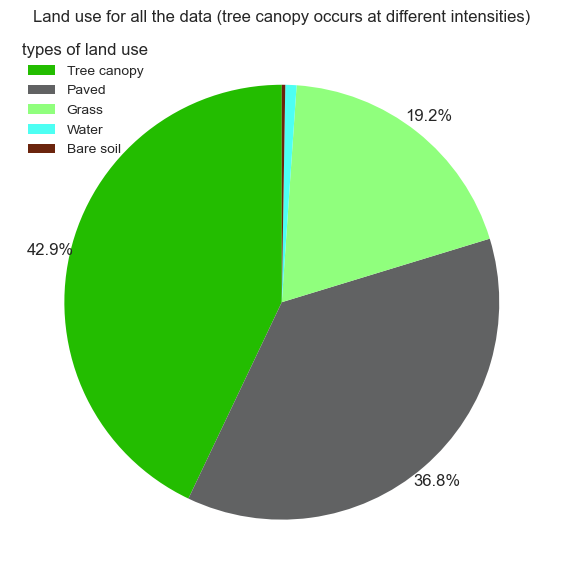

In [352]:
counts = df[(df.Type != 'Building')].Type.value_counts()

plt.figure(figsize=(6, 6))  
                                                                       #                                     Tree       Paved      Grass     Water      Bare soil
plt.pie(counts,  autopct=lambda p: f'{p:.1f}%' if p > 1 else '' , pctdistance=1.09, startangle=90, colors=['#23bd00', '#616263', '#90ff7d','#4dfff3', '#6b240d'])
                                                                                                        
plt.legend(counts.index, title='types of land use')     

plt.title('Land use for all the data (tree canopy occurs at different intensities)')

plt.tight_layout()
plt.savefig('Graphs/piechart_all_land_use.png', dpi = 500)
plt.show()

In [28]:
frequencies = dict()
for f in df.Type.unique():
    frequencies[f] = round(df[df.Type == f].shape[0]/df.shape[0], 4)
print(frequencies)

{'Grass': 0.1911, 'Paved': 0.3663, 'Building': 0.0042, 'Water': 0.0083, 'Bare soil': 0.0025, 'Tree canopy': 0.4275}


In [29]:
from mpl_toolkits.mplot3d import Axes3D
from colour import Color
from matplotlib.colors import ListedColormap

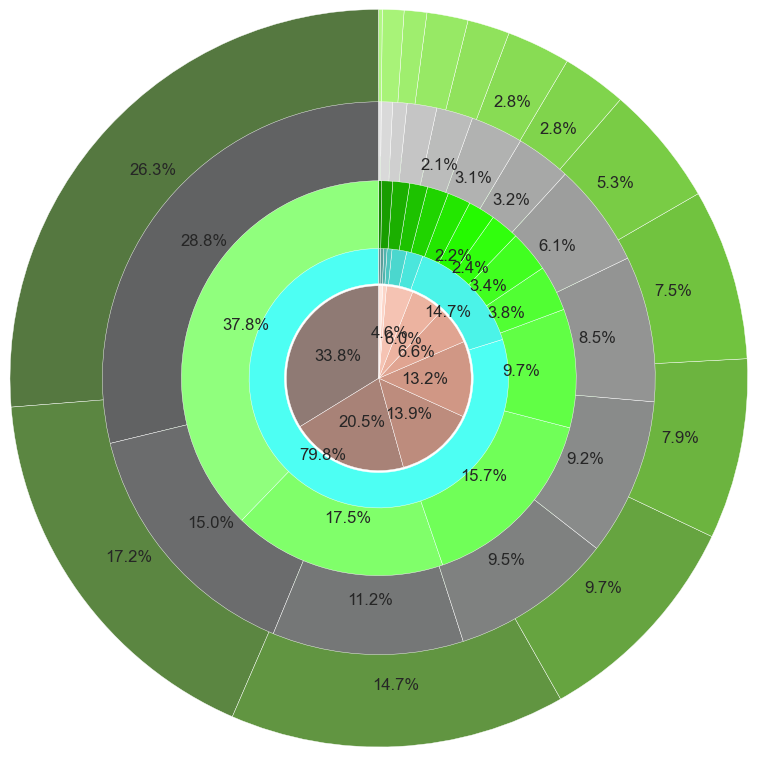

In [53]:
fig, ax = plt.subplots(figsize=(6,6))

size = 0.5
inner_radius = 0.5

soil = df[df.Type == 'Bare soil'].cl_morni.value_counts()
colors_soil = list(Color('#8f7a74').range_to(Color("#ffe8e0"), len(soil)))
colors_soil = [str(color) for color in colors_soil]
ax.pie(soil, radius = inner_radius , startangle = 90,
       autopct  = lambda p: f'{p:.1f}%' if p > 1 else '' , 
       pctdistance = 1-(1/(4*(inner_radius + frequencies['Bare soil']))), 
       colors = colors_soil,
       wedgeprops= {'width': size, 'edgecolor': 'w'}) 

water = df[df.Type == 'Water'].cl_morni.value_counts()
colors_water = list(Color('#4dfff3').range_to(Color("#638785"), len(water)))
colors_water = [str(color) for color in colors_water]
ax.pie(water, radius = inner_radius + size +frequencies['Water'] + frequencies['Bare soil'], startangle = 90, 
       autopct = lambda p: f'{p:.1f}%' if p > 4 else '' ,
       pctdistance = 1-(1/(4*(inner_radius+frequencies['Water'] + frequencies['Bare soil']))), colors = colors_water, 
       wedgeprops= {'width': size, 'edgecolor': 'w'})

grass = df[df.Type == 'Grass'].cl_morni.value_counts()
colors_grass = list(Color('#90ff7d').range_to(Color("#158a00"), len(grass)))
colors_grass = [str(color) for color in colors_grass]
ax.pie(grass, radius = inner_radius + size +frequencies['Grass'] + frequencies['Water'] + frequencies['Bare soil'], startangle = 90, 
       autopct = lambda p: f'{p:.1f}%' if p > 2 else '' , 
       pctdistance = 1-(1/(4*(inner_radius+ frequencies['Grass'] + frequencies['Water'] + frequencies['Bare soil']))), colors = colors_grass, 
       wedgeprops= {'width': size, 'edgecolor': 'w'})

paved = df[df.Type == 'Paved'].cl_morni.value_counts()
colors_paved = list(Color('#616263').range_to(Color("#e3e3e3"), len(paved)))
colors_paved = [str(color) for color in colors_paved]
ax.pie(paved, radius = inner_radius + size +frequencies['Paved'] + frequencies['Grass'] + frequencies['Water'] + frequencies['Bare soil'], startangle = 90, 
       autopct = lambda p: f'{p:.1f}%' if p > 2 else '' ,
       pctdistance = 1-(1/(4*(inner_radius+frequencies['Paved'] + frequencies['Grass'] + frequencies['Water'] + frequencies['Bare soil']))), colors = colors_paved, 
       wedgeprops= {'width': size, 'edgecolor': 'w'})

canopy = df[df.Type == 'Tree canopy'].cl_morni.value_counts()
colors_canopy = list(Color('#557840').range_to(Color("#b0f783"), len(canopy)))
colors_canopy = [str(color) for color in colors_canopy]
ax.pie(canopy, radius = inner_radius + size +frequencies['Tree canopy'] + frequencies['Paved'] + frequencies['Grass'] + frequencies['Water'] + frequencies['Bare soil'], startangle = 90, 
       autopct = lambda p: f'{p:.1f}%' if p > 2 else '' ,
       pctdistance = 1-(1/(4*(inner_radius+frequencies['Tree canopy'] + frequencies['Paved'] + frequencies['Grass'] + frequencies['Water'] + frequencies['Bare soil']))), colors = colors_canopy, 
       wedgeprops= {'width': size, 'edgecolor': 'w'})


plt.show()

In [68]:
from matplotlib.colors import ListedColormap


/home/fluve/anaconda3/envs/python3_8/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/fluve/anaconda3/envs/python3_8/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/fluve/anaconda3/envs/python3_8/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/hom

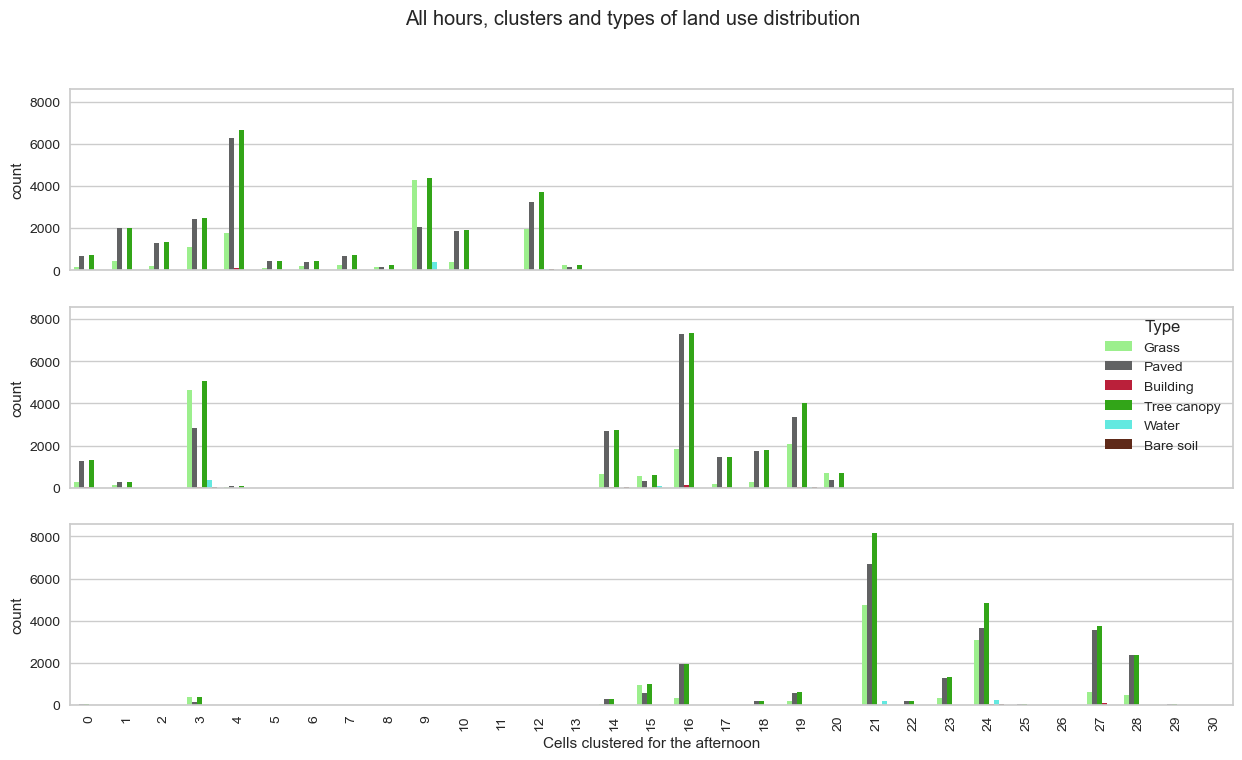

In [134]:
fig, axes = plt.subplots(3, 1, figsize=(15, 8), sharey=True, sharex=True)
l = ['#90ff7d', '#616263', '#d40629', '#23bd00', '#4dfff3', '#6b240d']

lab = [i for i in range(0,50)] 
sns.countplot(data=df, x='cl_morni', hue='Type', ax=axes[0], legend=False, palette = l)
axes[0].set_xticklabels(lab, rotation=90)
axes[0].set_xlabel('Cells clustered for the morning')

sns.countplot(data=df, x='cl_midda', hue='Type', ax=axes[1], legend=True, palette = l )
axes[1].set_xticklabels(lab, rotation=90)
axes[1].set_xlabel('Cells clustered for the midday')

sns.countplot(data=df, x='cl_after', hue='Type', ax=axes[2], legend=False,  palette = ['#90ff7d', '#616263', '#23bd00', '#d40629', '#4dfff3', '#6b240d'] )
axes[2].set_xticklabels(lab, rotation=90)
axes[2].set_xlabel('Cells clustered for the afternoon')

plt.suptitle("All hours, clusters and types of land use distribution")
plt.subplots_adjust(wspace=00)
plt.savefig('Graphs/All_hours_clusters_types_ofLanduse_histogram.png', dpi=500)
plt.show()

I believe these plots are more informative when discerning the distribution of the clusters, and since clusters were made as hour-sensitive, we can actually see how different hours of the day bring different insights. 

#### Simple spatial regression model 

In [159]:
import pysal
import pysal.model as spm
import pysal.lib as ps
from pysal.model import spreg


In [148]:
df['daily_avg_PET'] = (df['h7'] + df['h8'] + df['h9'] + df['h10'] + df['h11'] + df['h12'] +df['h13'] + df['h14'] + df['h15'] + df['h16'] + df['h17'] + df['h18'] + df['h19']) /  12

In [149]:
df.columns

Index(['id', 'Type', 'Tree', 'BUILDING', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12',
       'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'cl_morni', 'cl_midda',
       'cl_after', 'geometry', 'daily_avg_PET'],
      dtype='object')

/home/fluve/anaconda3/envs/python3_8/lib/python3.12/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2143 disconnected components.
  warnings.warn(message)
/home/fluve/anaconda3/envs/python3_8/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


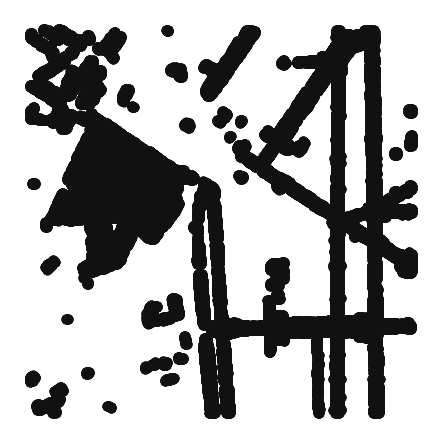

In [164]:
model_data = df[['Type', 'daily_avg_PET', 'geometry']]

weights = pysal.lib.weights.KNN.from_dataframe(model_data, k=3)

axis = model_data.plot(edgecolor="lightgray", facecolor="none")

model_data["index"] = model_data.index

weights.plot(gdf=model_data, indexed_on="index", ax=axis)

axis.set_axis_off()
plt.show()

From Michael Minn's post: The weights matrix can be passed to the OLS() function along with the spat_diag and moran parameters to display spatial autocorrelation statistics at the bottom of the model summary. (https://michaelminn.net/tutorials/python-regression/index.html#:~:text=To%20use%20the%20spatial%20regression,are%20the%20nearest%20k%20features.)

In [ ]:
model_data = pd.get_dummies(model_data, columns=['Type'], prefix='Type', drop_first=True)

In [374]:
for col in ['Type_Building', 'Type_Grass', 'Type_Paved', 'Type_Tree canopy', 'Type_Water']:
    model_data.loc[:,f'{col}'] = model_data[f'{col}'].astype(int)

In [375]:
print(model_data.Type_Grass.dtype)
model_data.columns

int64


Index(['daily_avg_PET', 'geometry', 'index', 'Type_Building', 'Type_Grass',
       'Type_Paved', 'Type_Tree canopy', 'Type_Water'],
      dtype='object')

In [ ]:
ols_model = pysal.model.spreg.OLS(model_data['daily_avg_PET'].values,
        model_data[['Type_Building', 'Type_Grass', 'Type_Paved', 'Type_Tree canopy', 'Type_Water']].values, weights, spat_diag = True, moran=True,
        name_y = 'daily_avg_PET', name_x = ['Type_Building', 'Type_Grass', 'Type_Paved', 'Type_Tree canopy', 'Type_Water'])

print(ols_model.summary)

In [377]:

subset_model_data = model_data.sample(n=int(model_data.shape[0]*(1/50)), random_state=25)
weights = pysal.lib.weights.KNN.from_dataframe(subset_model_data, k=3)

lag_model = pysal.model.spreg.ML_Lag(subset_model_data['daily_avg_PET'].values,
        subset_model_data[['Type_Building', 'Type_Grass', 'Type_Paved', 'Type_Tree canopy', 'Type_Water']].values, weights,
	name_y = 'daily_avg_PET', name_x = ['Type_Building', 'Type_Grass', 'Type_Paved', 'Type_Tree canopy', 'Type_Water'])

print(lag_model.summary)

/home/fluve/anaconda3/envs/python3_8/lib/python3.12/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 41 disconnected components.
  warnings.warn(message)
/home/fluve/anaconda3/envs/python3_8/lib/python3.12/site-packages/spreg/ml_lag.py:634: RuntimeWarning: invalid value encountered in log
  jacob = np.log(np.linalg.det(a))


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :daily_avg_PET                Number of Observations:        1186
Mean dependent var  :     36.0748                Number of Variables   :           7
S.D. dependent var  :      1.8275                Degrees of Freedom    :        1179
Pseudo R-squared    :      0.3215
Spatial Pseudo R-squared:  0.0122
Log likelihood      :  -2242.4501
Sigma-square ML     :      2.3677                Akaike info criterion :    4498.900
S.E of regression   :      1.5387                Schwarz criterion     :    4534.449

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------------------------------------------------------------

As exp 

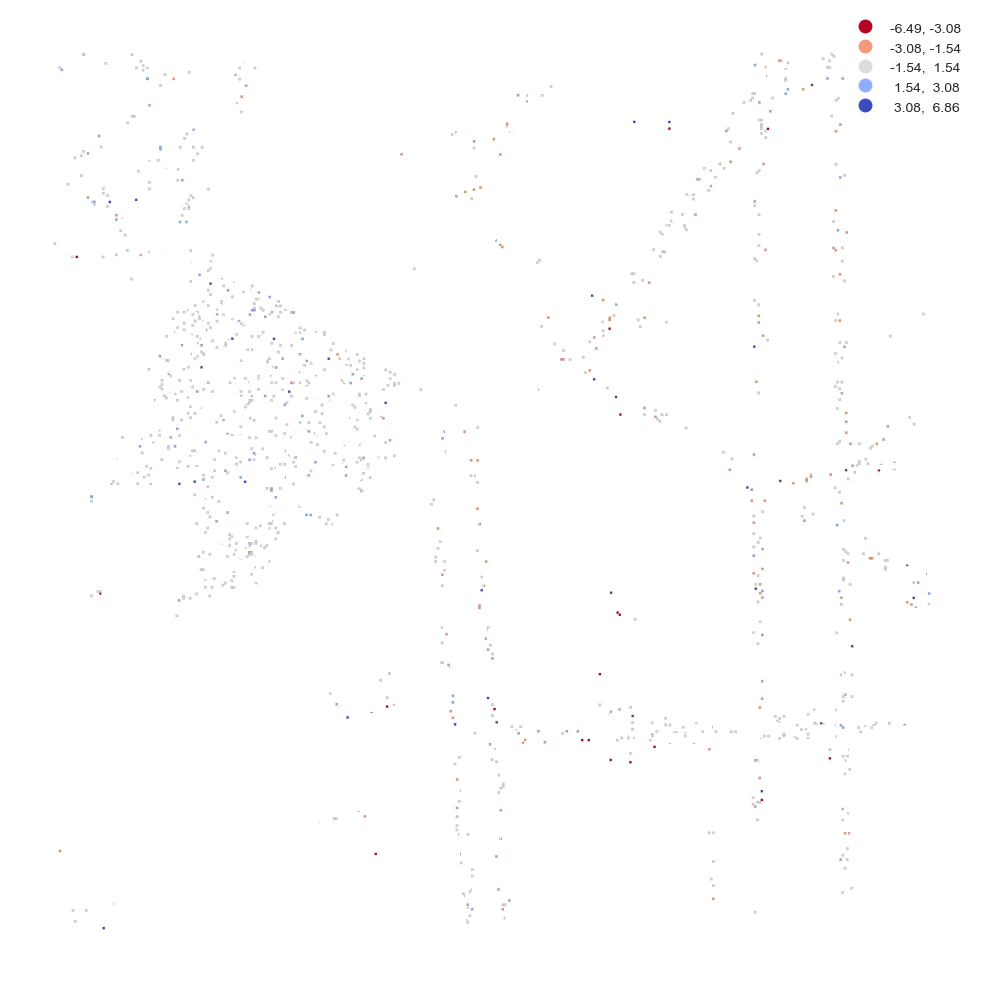

In [224]:
fig, ax = plt.subplots(figsize=(10, 10))
subset_model_data["Residuals"] = lag_model.u

subset_model_data.plot("Residuals", legend=True, scheme="stdmean",
                       cmap="coolwarm_r", edgecolor="#00000040", ax=ax)

ax.set_axis_off()
plt.tight_layout()
plt.savefig('Graphs/Spatial_lag_regression.png', dpi=500)
plt.show()

In [ ]:
subset_model_data.to_file('Dataset 3/Spatial lag residuals/residuals.shp')

In [369]:
df[['id', 'cl_morni','geometry']].to_file('Dataset 3/Hourly clusters/morning_clusters.shp')

In [370]:
df[['id', 'cl_midda','geometry']].to_file('Dataset 3/Hourly clusters/midday_clusters.shp')

In [371]:
df[['id', 'cl_after','geometry']].to_file('Dataset 3/Hourly clusters/afternoon_clusters.shp')

In QGIS, I then make some maps to visualize the clusters based on the hour of the day. 